# Upload Files from Local Drive

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving GDP(2022).csv to GDP(2022).csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import aic, bic
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
import os

# Helper Functions

## data.py

### Automatically detect date column - return the corresponding column name

In [ ]:
def detect_date_column(df: pd.DataFrame) -> str:
    """
    Automatically detects the column in the DataFrame that contains date-like information,
    including quarterly data in the format "YYYY Qx".

    Parameters:
        df (pd.DataFrame): The DataFrame to search for date columns.

    Returns:
        str: The name of the detected date column, or None if no date column is found.
    """
    for column in df.columns:
        try:
            # Convert column to string if it's not already a string type
            if df[column].dtype != 'O':  # Not object type (string)
                df[column] = df[column].astype(str)

            # Check if column values are in "YYYY Qx" format (e.g., "2021 Q1")
            if df[column].str.contains(r'\d{4} Q[1-4]', na=False).any():
                return column  # Return the column name if it contains "YYYY Qx" format

            # Try to convert the column to datetime for standard date formats
            pd.to_datetime(df[column], errors='raise')
            return column  # Return the column name if it's a valid date column
        except (ValueError, TypeError):
            continue
    return None  # Return None if no valid date column is found


### Convert Date Column (Quarterly) to DateTime format - can't parse automatically

In [ ]:
def convert_quarter_to_date(quarter_str: str) -> pd.Timestamp:
    """
    Converts a quarterly string (e.g., "2021 Q1") to the corresponding date (e.g., "2021-01-01").
    This function is flexible and can work with any quarterly string containing "YYYY Qx".

    Parameters:
        quarter_str (str): The quarterly string (e.g., "2021 Q1").

    Returns:
        pd.Timestamp: The corresponding datetime object (e.g., "2021-01-01").
    """
    # Split the string into year and quarter parts
    parts = quarter_str.split(" Q")
    if len(parts) == 2:
        year, quarter = parts
        # Handle the case where the string contains a valid year and quarter
        try:
            year = int(year)
            quarter = int(quarter)
            # Map quarters to the first month of each quarter
            quarter_months = {1: 1, 2: 4, 3: 7, 4: 10}
            if quarter in quarter_months:
                month = quarter_months[quarter]
                return pd.to_datetime(f"{year}-{month:02d}-01")
        except ValueError:
            pass  # If parsing fails, return NaT (could be invalid data)
    return pd.NaT  # Return NaT if the input string is not in a valid "YYYY Qx" format

### Data cleaning

In [ ]:
def clean_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans a DataFrame by stripping column names and converting date columns to datetime format.
    If a column is detected as a date, it is renamed to 'Date'.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The cleaned DataFrame.
    """
    # Clean column names (remove leading/trailing spaces)
    df.columns = df.columns.str.strip()

    date_column = detect_date_column(df)

    if date_column:
        # Check if the column contains quarterly-like data (e.g., "YYYY Qx")
        if df[date_column].dtype == object and df[date_column].str.contains(r'\d{4} Q[1-4]', na=False).any():
            # Convert the "YYYY Qx" format to datetime dynamically
            df[date_column] = df[date_column].apply(convert_quarter_to_date)
        else:
            # For standard date formats, convert to datetime
            df[date_column] = pd.to_datetime(df[date_column], errors="coerce")

        # Rename the date column to 'Date'
        df.rename(columns={date_column: 'Date'}, inplace=True)

    return df

### Load dataset - Load all the datasets in the "data" folder and automatically split them into the corresponding crisis lists

In [ ]:
def load_dataset(folder_path: str = "data", crisis_years: list = []) -> dict:
    """
    Loads all CSV datasets from a specified folder, applies cleaning operations,
    and splits them based on specified crisis years.

    Parameters:
        folder_path (str): The path to the folder containing CSV files. Defaults to "data".
        crisis_years (list): List of years representing the crisis periods (e.g., [2008, 2022]).

    Returns:
        dict: A dictionary where the keys are crisis years (e.g., 2008, 2022) and the values
              are lists of DataFrames corresponding to each crisis year.
    """
    crisis_data = {year: [] for year in crisis_years}  # Initialize a list for each crisis year

    # Iterate over all CSV files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)

            # Clean the dataset
            df = clean_dataset(df)

            # Automatically detect the date column
            date_column = detect_date_column(df)

            if date_column:
                df[date_column] = pd.to_datetime(df[date_column], errors='coerce')  # Convert to datetime
                df["Year"] = df[date_column].dt.year

                # Check if the dataset contains any data from the crisis years
                unique_years = df["Year"].unique()  # Get unique years in dataset
                for year in crisis_years:
                    if year in unique_years:
                        crisis_data[year].append(df)  # Add entire dataset to corresponding crisis year

                df.drop(columns=["Year"], inplace=True)  # Remove temporary Year column

    return crisis_data

### Normalisation (Z-score normalisation)

In [ ]:
def normalisation(df, normalization_type='z-score', columns=None):
    """
    Normalizes the numeric columns of a DataFrame using the specified normalization method.

    Args:
    - df (pd.DataFrame): The DataFrame to normalize.
    - normalization_type (str): The type of normalization to apply. Options are 'z-score' or 'min-max'. Default is 'z-score'.
    - columns (list or None): List of column names to normalize. If None, normalizes all numeric columns.

    Returns:
    - pd.DataFrame: DataFrame with normalized values.
    """
    # Select numeric columns
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

    if columns is not None:
        # Use provided columns, ensuring they are numeric
        numeric_columns = [col for col in columns if col in numeric_columns]

    if len(numeric_columns) == 0:
        raise ValueError("No numeric columns to normalize in the provided DataFrame.")

    # Select the normalization method
    if normalization_type == 'z-score':
        scaler = StandardScaler()
    elif normalization_type == 'min-max':
        scaler = MinMaxScaler()
    else:
        raise ValueError(f"Unknown normalization type: {normalization_type}. Supported types are 'z-score' and 'min-max'.")

    # Apply the scaler to the numeric columns
    normalized_data = scaler.fit_transform(df[numeric_columns])

    # Convert the normalized data back to a DataFrame
    normalized_df = df.copy()
    normalized_df[numeric_columns] = normalized_data

    return normalized_df


### Adjust column values - for government support scheme

In [ ]:
def adjust_column_for_periods(df: pd.DataFrame, periods: list):
    """
    Adjusts specified columns in a DataFrame based on multiple periods with varying start/end dates and values.

    Args:
    - df (pd.DataFrame): The DataFrame containing the data.
    - periods (list): A list of dictionaries, where each dictionary contains:
        - 'start': start date of the period (str or datetime)
        - 'end': end date of the period (str or datetime)
        - 'column': the name of the column to adjust (str)
        - 'value': the adjustment value to apply during the period (int, float, or str)

    Returns:
    - pd.DataFrame: The adjusted DataFrame.
    """
    # Copy the original DataFrame to avoid modifying the input DataFrame directly
    adjusted_df = df.copy()

    for period in periods:
        # Convert start and end dates to datetime
        start_date = pd.to_datetime(period['start'])
        end_date = pd.to_datetime(period['end'])

        # Check if the column exists in the DataFrame
        column = period['column']
        if column not in adjusted_df.columns:
            raise ValueError(f"Column '{column}' not found in the DataFrame.")

        # Apply the adjustment based on the period
        adjusted_df.loc[
            (adjusted_df['Date'] >= start_date) &
            (adjusted_df['Date'] <= end_date),
            column
        ] = period['value']

    return adjusted_df

### Preprocess quarterly data - resampled

In [ ]:
def preprocess_data(df: pd.DataFrame, freq: str = 'MS', method: str = 'ffill') -> pd.DataFrame:
    """
    Preprocesses a DataFrame by converting date formats and resampling it to a given frequency.

    This version supports various types of date formats and resampling methods.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        freq (str): The resampling frequency. Default is 'MS' (monthly start).
                    Other options include 'D' (daily), 'M' (monthly), 'Y' (yearly), etc.
        method (str): Method for filling missing data during resampling. Default is 'ffill' (forward fill).
                      Other options: 'bfill' (backward fill), 'pad' (pad), 'nearest', etc.

    Returns:
        pd.DataFrame: Preprocessed DataFrame with resampled data.
    """
    df = df.dropna(subset=['Date'])

    df_resampled = df.set_index('Date').resample(freq).apply(method).reset_index()

    return df_resampled


### Merge multiple dataframes

In [ ]:
def merge_dataframes_on_date(*dfs):
    """
    Merges multiple dataframes on the 'Date' column.

    Parameters:
        *dfs: Multiple DataFrames to merge.

    Returns:
        pd.DataFrame: A single merged DataFrame on the 'Date' column.
    """
    # Preprocess each DataFrame before merging
    processed_dfs = [preprocess_data(df.copy()) for df in dfs]

    # Merge DataFrames on 'Date'
    merged_df = processed_dfs[0]
    for df in processed_dfs[1:]:
        merged_df = pd.merge(merged_df, df, on='Date', how='inner')

    return merged_df

### Select specific target column

In [ ]:
def filter_target_column(all_dfs, crisis_year, target_column):
    """
    Filters each DataFrame in the all_dfs list for a given 'target_column' and 'Date' column.

    Parameters:
        all_dfs (list): List of DataFrames to filter.
        crisis_year (str): The year or key indicating which group of DataFrames to filter.
        target_column (str): The column to filter along with 'Date'.

    Returns:
        None: Modifies the DataFrames in place.
    """
    # Loop through each DataFrame in the selected crisis_year
    for i, df in enumerate(all_dfs[crisis_year]):
        if target_column in df.columns:
            # Filter the DataFrame to only include 'Date' and the target column
            df_filtered = df[['Date', target_column]].copy()

            # Optionally, assign it back to the list to modify in place
            all_dfs[crisis_year][i] = df_filtered


## plot.py

### Plotting

In [ ]:
def plotting(df: pd.DataFrame,
             step_column=" ",
             title: str = None,
             x_label: str = None,
             y_label: str = None,
             annotation: dict = None,
             highlight: list = None):
    """
    Plots a time series graph for a dataset with a detected date column.
    Supports step charts, event highlighting, and shaded EPG periods.

    Parameters:
        df (pd.DataFrame): The dataset containing at least one date column and one value column.
        step_column (str): The column to be plotted as a step chart.
        title (str): Title of the plot (default: "Time Series Plot").
        x_label (str, optional): Label for the x-axis. Defaults to the detected date column name.
        y_label (str, optional): Label for the y-axis. Defaults to the value column names.
        annotation (dict, optional): {"Event Name": ("YYYY-MM-DD", with_line)}.
                                           If with_line=True, a vertical line is drawn.
        highlight (list of tuples, optional): List of EPG periods in format:
            [(start_date, end_date, price_level, label, color), ...].
        annotation_arrows (bool, optional): If True, event labels will be placed without vertical lines.
    """
    date_col = 'Date'
    if df.shape[1] < 2:
        raise ValueError("The DataFrame must contain at least two columns: a date column and at least one value column.")

    # Default axis labels
    if x_label is None:
        x_label = date_col
    if y_label is None:
        y_label = ", ".join(df.columns[df.columns != date_col])

    # Default title
    if title is None:
        title = y_label

    fig, ax1 = plt.subplots(figsize=(15, 8))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # Plotting main data
    for i, column in enumerate(df.columns[df.columns != date_col]):
        line_style = '-'
        marker_style = 'o'

        if step_column == column:
            ax1.step(df[date_col], df[step_column], where='post', linestyle='-',
                     color=colors[i % len(colors)], linewidth=2, label=f'{step_column} (Step)')
            continue

        ax1.plot(df[date_col], df[column], linestyle=line_style, marker=marker_style,
                 linewidth=2, markersize=6, color=colors[i % len(colors)], label=column)

    # Plot shaded bars
    if highlight:
        for start, end, price, label, color in highlight:
            width = (end - start).days
            middle = start + (end - start) / 2

            ax1.bar(x=start, height=price, width=width, color=color, alpha=0.2, align='edge', label=label)
            ax1.annotate(label, xy=(middle, price), xytext=(middle, price + 200),
                         arrowprops=dict(arrowstyle='->', color=color), color=color, fontsize=12, ha='center')

    # Highlight specific events (both with and without lines)
    if annotation:
        for event_name, (event_date, with_line) in annotation.items():
            event_date = pd.to_datetime(event_date)

            # Draw vertical line if required
            if with_line:
                ax1.axvline(x=event_date, color='red', linestyle='-', linewidth=2, label=event_name)

            # Annotate the event
            y_position = df.iloc[:, 1].max() - (200 if with_line else 100)

            # Annotate the event above the data points
            ax1.annotate(event_name,
             xy=(event_date, y_position),  # Annotation point
             xytext=(event_date + pd.DateOffset(days=150), y_position + 200),  # Offset text
             fontsize=12, color='red',
             ha='center',
             arrowprops=dict(arrowstyle='->', color='blue' if not with_line else 'red'))



    # Labels, title, and legend
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


## analysis.py

### Correlation matrix

In [ ]:
def plot_correlation_matrix(df: pd.DataFrame, title: str):
    """
    Plots a heatmap for the correlation matrix of all numeric columns (excluding 'Date') in the dataset.

    Parameters:
        df (pd.DataFrame): The dataset containing the 'Date' column and numeric columns.
        title (str): The title of the plot.
    """
    # Exclude the 'Date' column and select numeric columns
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

    # Calculate the correlation matrix for the numeric columns
    correlation_matrix = df[numeric_columns].corr()

    # Plot the heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)
    plt.title(title)
    plt.show()

### Granger Causality Class

In [ ]:
class GrangerCausalityAnalyzer:
    def __init__(self, data, maxlag=2, adf_significance=0.05, causality_significance=0.05):
        """
        Initializes the Granger Causality Analyzer.

        Parameters:
        - data: DataFrame containing the time-series variables.
        - maxlag: Maximum number of lags for Granger Causality tests (default=4).
        - adf_significance: Significance level for ADF test (default=0.05).
        - causality_significance: Significance level for Granger Causality test (default=0.05).
        """
        self.data = data
        self.maxlag = maxlag
        self.adf_significance = adf_significance
        self.causality_significance = causality_significance
        self.stationary_vars = {}
        self.stationarity_summary = {}
        self.causality_results = []

    def adf_test(self, series, name):
        """Performs the Augmented Dickey-Fuller (ADF) test for stationarity."""
        result = adfuller(series.dropna(), autolag='AIC')
        print(f'ADF Test for {name}:')
        print(f'ADF Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        print(f'Critical Values: {result[4]}')

        if result[1] <= self.adf_significance:
            print(f'{name} is stationary (reject null hypothesis)\n')
            return True, result[1]
        else:
            print(f'{name} is non-stationary (fail to reject null hypothesis)\n')
            return False, result[1]

    def transform_to_stationary(self):
        """Transforms non-stationary variables to stationary using differencing."""
        variables = [col for col in self.data.columns if col != 'Date']
        data_transformed = self.data[variables].copy()

        for var in variables:
            is_stationary, p_value = self.adf_test(data_transformed[var], var)
            if is_stationary:
                self.stationary_vars[var] = var
                self.stationarity_summary[var] = f"stationary (p-value = {p_value:.4f})"
            else:
                # First difference
                data_transformed[f'{var}_diff'] = data_transformed[var].diff()
                is_stationary, p_value = self.adf_test(data_transformed[f'{var}_diff'], f'Differenced {var}')
                if is_stationary:
                    self.stationary_vars[var] = f'{var}_diff'
                    self.stationarity_summary[var] = f"non-stationary, stationary after first differencing (p-value = {p_value:.4f})"
                else:
                    # Second difference
                    data_transformed[f'{var}_diff2'] = data_transformed[f'{var}_diff'].diff()
                    is_stationary, p_value = self.adf_test(data_transformed[f'{var}_diff2'], f'Second Differenced {var}')
                    if is_stationary:
                        self.stationary_vars[var] = f'{var}_diff2'
                        self.stationarity_summary[var] = f"non-stationary, stationary after second differencing (p-value = {p_value:.4f})"
                    else:
                        self.stationary_vars[var] = f'{var}_diff2'
                        self.stationarity_summary[var] = f"non-stationary even after second differencing (p-value = {p_value:.4f})"

        # Create final stationary dataset
        stationary_columns = [self.stationary_vars[var] for var in variables]
        data_stationary = data_transformed[stationary_columns].dropna()
        data_stationary.columns = variables  # Rename columns to original names for clarity
        self.data_stationary = data_stationary

        print("Stationary dataset created:")
        print(self.data_stationary.head())
        print("\nNaN values in stationary dataset:")
        print(self.data_stationary.isna().sum())

        return self.data_stationary

    def run_granger_causality_tests(self):
        """Runs Granger Causality tests on stationary variables."""
        print("\nRunning Granger Causality Tests...\n")
        variables = list(self.stationary_vars.keys())

        for i, var1 in enumerate(variables):
            for j, var2 in enumerate(variables):
                if i != j:
                    print(f'Granger Causality Test: {var2} -> {var1}')
                    test_results = grangercausalitytests(self.data_stationary[[var1, var2]], maxlag=self.maxlag, verbose=True)

                    # Parse the results dictionary
                    for lag, result in test_results.items():
                        p_value = result[0]['ssr_ftest'][1]  # Extract p-value
                        if p_value <= self.causality_significance:
                            self.causality_results.append({'cause': var2, 'effect': var1, 'lag': lag, 'p_value': p_value})

                    print("\n" + "="*50 + "\n")

    def generate_conclusion(self):
        """Generates a summary of the findings from the Granger Causality tests."""
        print("\nConclusion: Granger Causality Analysis of Economic Indicators\n")

        # Stationarity Summary
        print("Stationarity Analysis:")
        for var, summary in self.stationarity_summary.items():
            print(f"- {var}: {summary}")
        print("\n")

        # Granger Causality Findings
        print("Granger Causality Findings:")
        if self.causality_results:
            for result in self.causality_results:
                print(f"- {result['cause']} Granger-causes {result['effect']} at lag {result['lag']} (p-value = {result['p_value']:.4f})")
        else:
            print("- No significant Granger Causality relationships were found.")
        print("\n")

    def run_workflow(self):
        """Executes the full workflow: transformation, Granger Causality, and conclusion."""
        self.transform_to_stationary()
        self.run_granger_causality_tests()
        self.generate_conclusion()


### Lasso Regression - Feature Selection

In [ ]:
def lasso_feature_selection(df, target_column='GDP', test_size=0.2, random_state=42):
    """
    Performs LASSO regression for feature selection on a dataset.

    Parameters:
        df (pd.DataFrame): The dataset containing economic indicators and a target variable.
        target_column (str): The name of the column to predict (e.g., 'GDP').
        test_size (float): The proportion of the dataset to use for testing.
        random_state (int): Random seed for reproducibility.

    Returns:
        list: Selected features from LASSO.
    """
    # Drop target and non-numeric columns
    X = df.drop(columns=[target_column, 'Date'], errors='ignore')
    y = df[target_column]

    # Handle missing values by filling with the median
    X.fillna(X.median(), inplace=True)

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state)

    # Define hyperparameter range for alpha
    params = {"alpha": np.linspace(0.00001, 10, 500)}

    # Use K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

    # Initialize LASSO and perform GridSearchCV
    lasso = Lasso()
    lasso_cv = GridSearchCV(lasso, param_grid=params, cv=kf)
    lasso_cv.fit(X_scaled, y)

    # Get best alpha parameter
    best_alpha = lasso_cv.best_params_["alpha"]
    print(f"Best Alpha: {best_alpha}")

    # Train LASSO with best alpha
    lasso = Lasso(alpha=best_alpha)
    lasso.fit(X_train, y_train)

    # Select important features (non-zero coefficients)
    selected_features = X.columns[lasso.coef_ != 0].tolist()
    print("Selected Features by LASSO:", selected_features)

    # Plot feature importance
    plt.figure(figsize=(15, 8))
    plt.bar(selected_features, lasso.coef_[lasso.coef_ != 0], color='blue')
    plt.xlabel("Features")
    plt.ylabel("LASSO Coefficient")
    plt.title("Feature Importance from LASSO Regression")
    plt.xticks(rotation=45)
    plt.show()

    return selected_features

### Plot Multiple Linear Regression

In [ ]:
class TimeSeriesRegression:
    def __init__(self, df, features, target, max_lag=6):
        """
        Initializes the TimeSeriesRegression model.

        Parameters:
            df (pd.DataFrame): The dataset.
            features (list): List of feature column names.
            target (str): Target variable.
            max_lag (int): Maximum lag to consider.
        """
        self.df = df.copy()
        self.features = features
        self.target = target
        self.max_lag = max_lag
        self.best_lags = {}

    def find_best_lags(self):
        """Finds the optimal lag for each feature using time-series cross-validation."""
        tscv = TimeSeriesSplit(n_splits=5)

        for feature in self.features:
            best_mse = float('inf')
            best_lag = 0

            for lag in range(1, self.max_lag + 1):
                df_lagged = self.df[[feature, self.target]].copy()
                df_lagged[f"{feature}_lag"] = df_lagged[feature].shift(lag)
                df_lagged.dropna(inplace=True)

                X = df_lagged[[f"{feature}_lag"]]
                y = df_lagged[self.target]

                mse_list = []

                for train_index, test_index in tscv.split(X):
                    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                    model = LinearRegression()
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)

                    mse = mean_squared_error(y_test, y_pred)
                    mse_list.append(mse)

                avg_mse = np.mean(mse_list)

                if avg_mse < best_mse:
                    best_mse = avg_mse
                    best_lag = lag

            self.best_lags[feature] = best_lag  # Store best lag

    def create_lagged_dataset(self):
        """Creates a DataFrame with the best lagged features."""
        self.df_lagged = self.df.copy()
        for feature, lag in self.best_lags.items():
            self.df_lagged[f"{feature}_lag"] = self.df_lagged[feature].shift(lag)

        self.df_lagged.dropna(inplace=True)  # Remove NaN rows
        return self.df_lagged

    def train_model(self):
        """Trains a multiple linear regression model using the best lags."""
        X = self.df_lagged[[f"{feat}_lag" for feat in self.best_lags.keys()]]
        y = self.df_lagged[self.target]

        self.model = LinearRegression()
        self.model.fit(X, y)

        # Predict & Evaluate
        self.y_pred = self.model.predict(X)
        self.mse = mean_squared_error(y, self.y_pred)
        print(f"Final Model MSE: {self.mse}")

    def plot_actual_vs_predicted(self):
        """Plot actual vs predicted values."""
        plt.figure(figsize=(10, 6))
        plt.scatter(self.df_lagged[self.target], self.y_pred, color='blue', alpha=0.6, label="Actual vs Predicted")
        plt.plot(self.df_lagged[self.target], self.df_lagged[self.target], color='red', linestyle='--', label="Perfect Fit")
        plt.xlabel("Actual " + self.target)
        plt.ylabel("Predicted " + self.target)
        plt.title(f"Actual vs Predicted: {self.target}")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_residuals(self):
        """Plot residuals of the model."""
        residuals = self.df_lagged[self.target] - self.y_pred
        plt.figure(figsize=(10, 6))
        plt.scatter(self.df_lagged[self.target], residuals, color='green', alpha=0.6, label="Residuals")
        plt.axhline(y=0, color='red', linestyle='--', label="Zero Residual Line")
        plt.xlabel("Actual " + self.target)
        plt.ylabel("Residuals")
        plt.title(f"Residuals Plot: {self.target}")
        plt.legend()
        plt.grid(True)
        plt.show()

    def run(self):
        """Executes the full pipeline: find best lags, create dataset, train model, and plot results."""
        print("Finding best lags...")
        self.find_best_lags()
        print(f"Best lags: {self.best_lags}")

        print("Creating lagged dataset...")
        self.create_lagged_dataset()

        print("Training model...")
        self.train_model()

        # Plotting results
        self.plot_actual_vs_predicted()
        self.plot_residuals()



# main.py


## Load the entire dataset in the data folder

In [ ]:
crisis_list = [2008, 2022]

all_dfs = load_dataset("data", crisis_list)

<ipython-input-3-ad2170158bc3>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df[column], errors='raise')
<ipython-input-5-2500689bc7ba>:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_column] = pd.to_datetime(df[date_column], errors="coerce")
<ipython-input-3-ad2170158bc3>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df[column], errors='raise')
<ipython-input-5-2500689bc7ba>:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-

## 2008 Global Financial Crisis

### Plot all the datasets collected at once

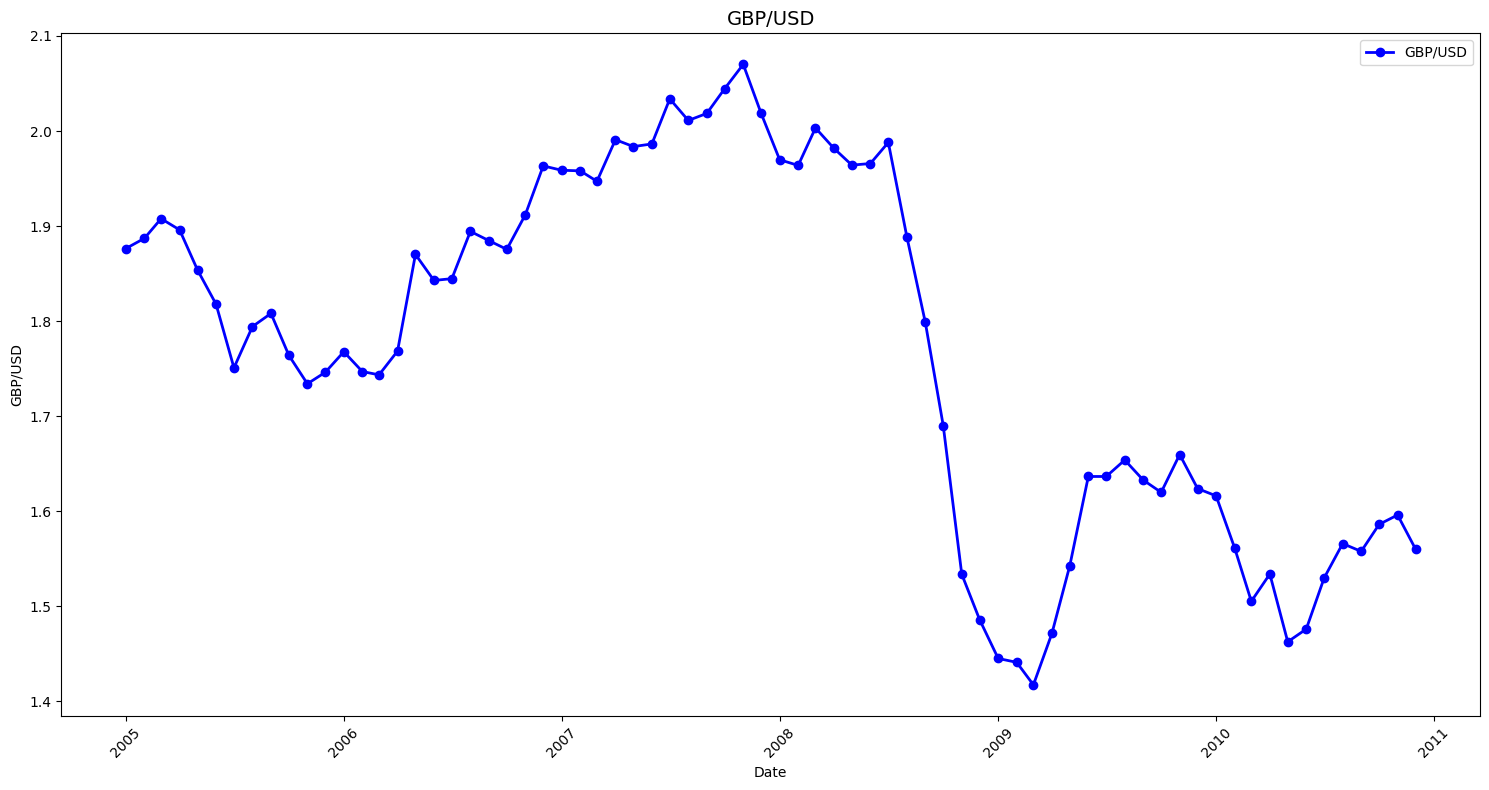

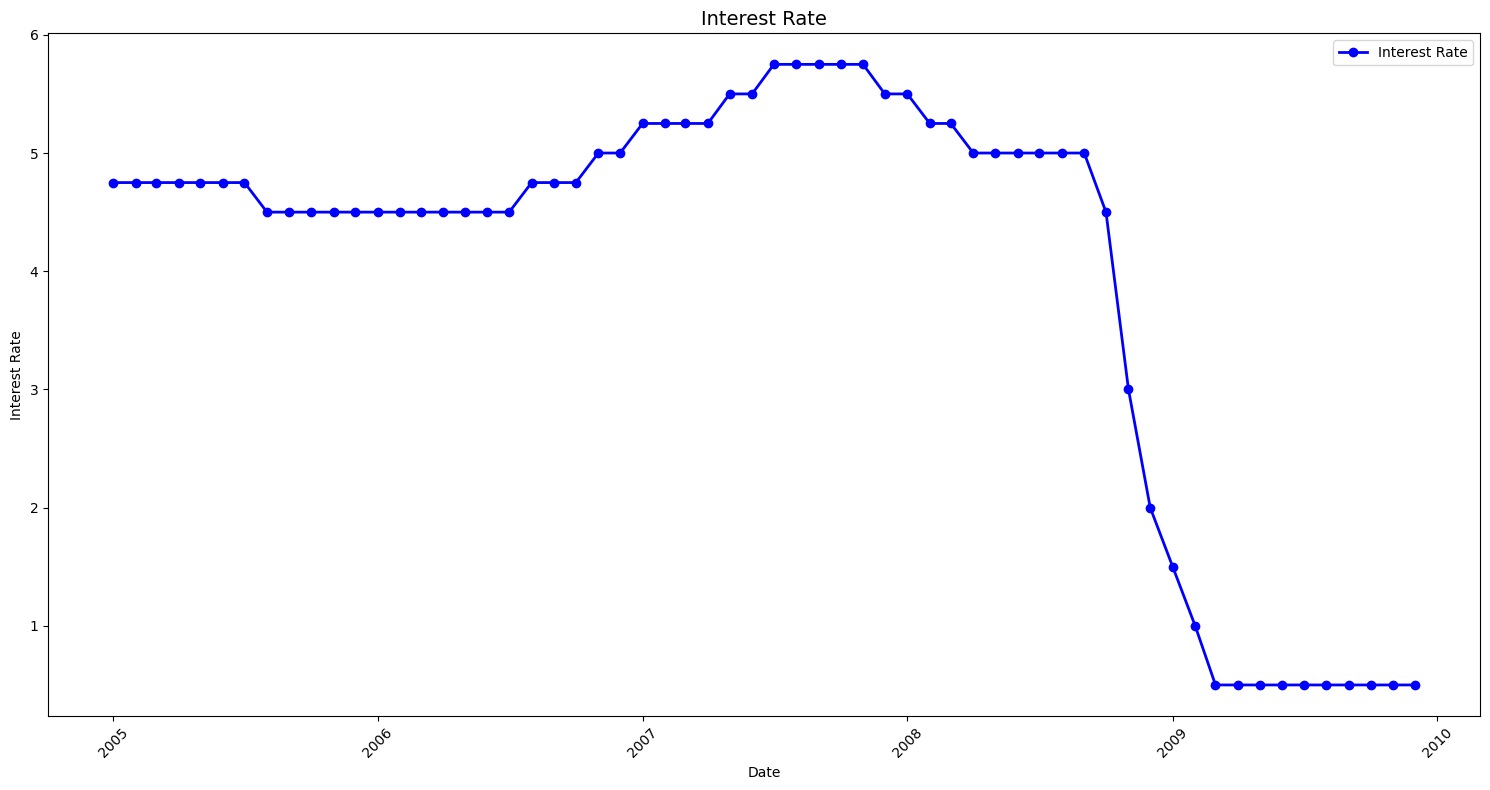

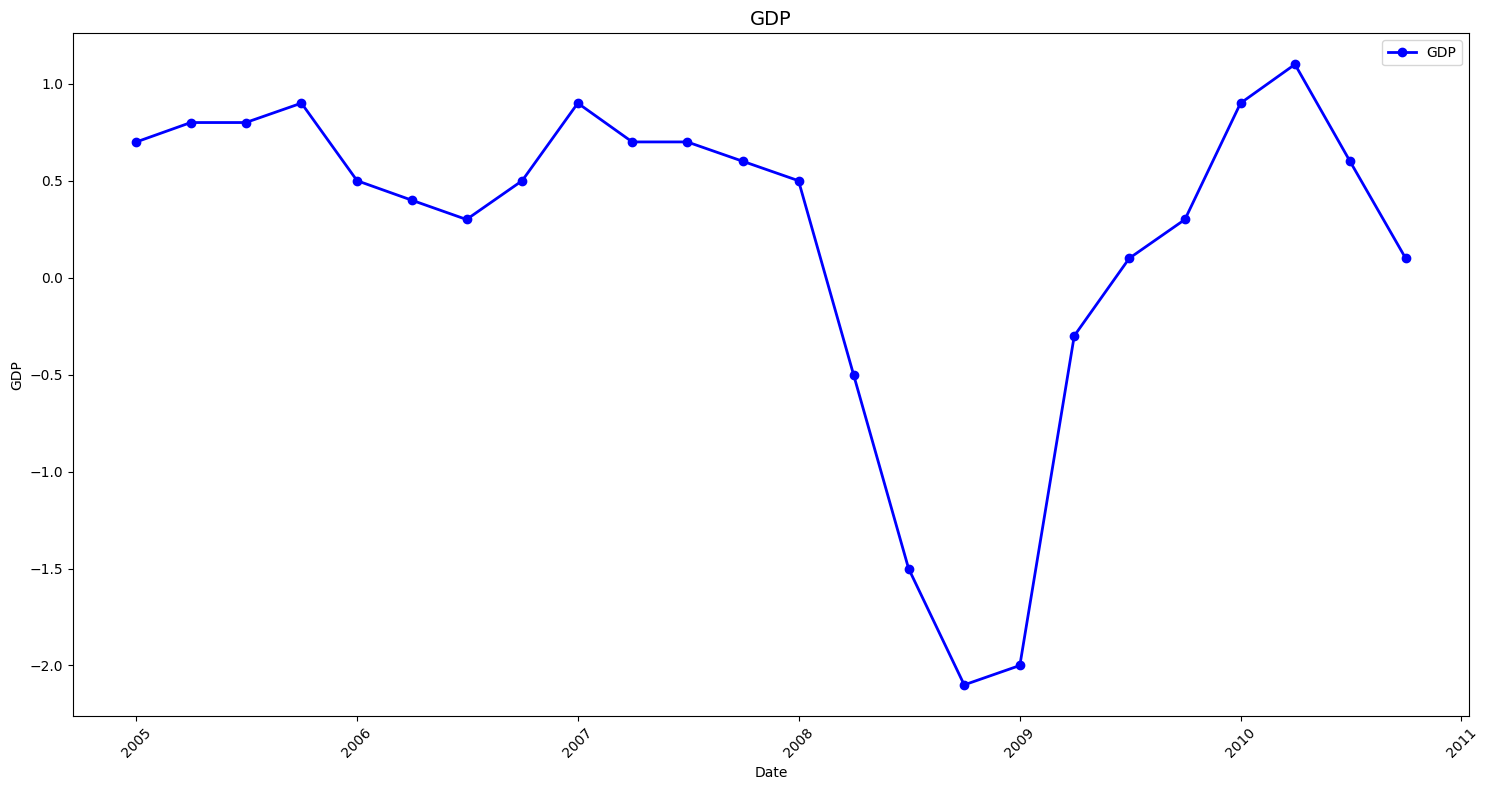

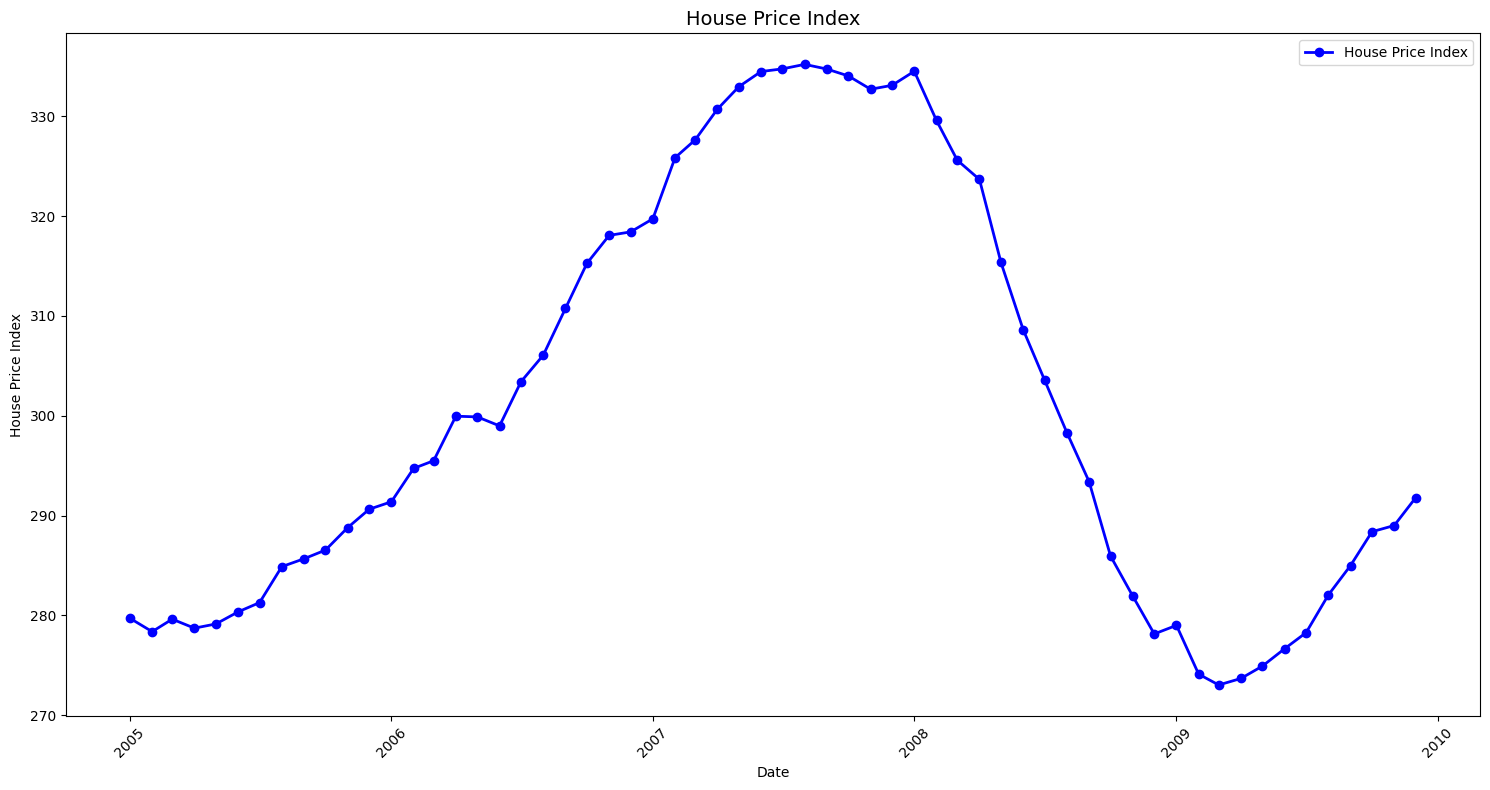

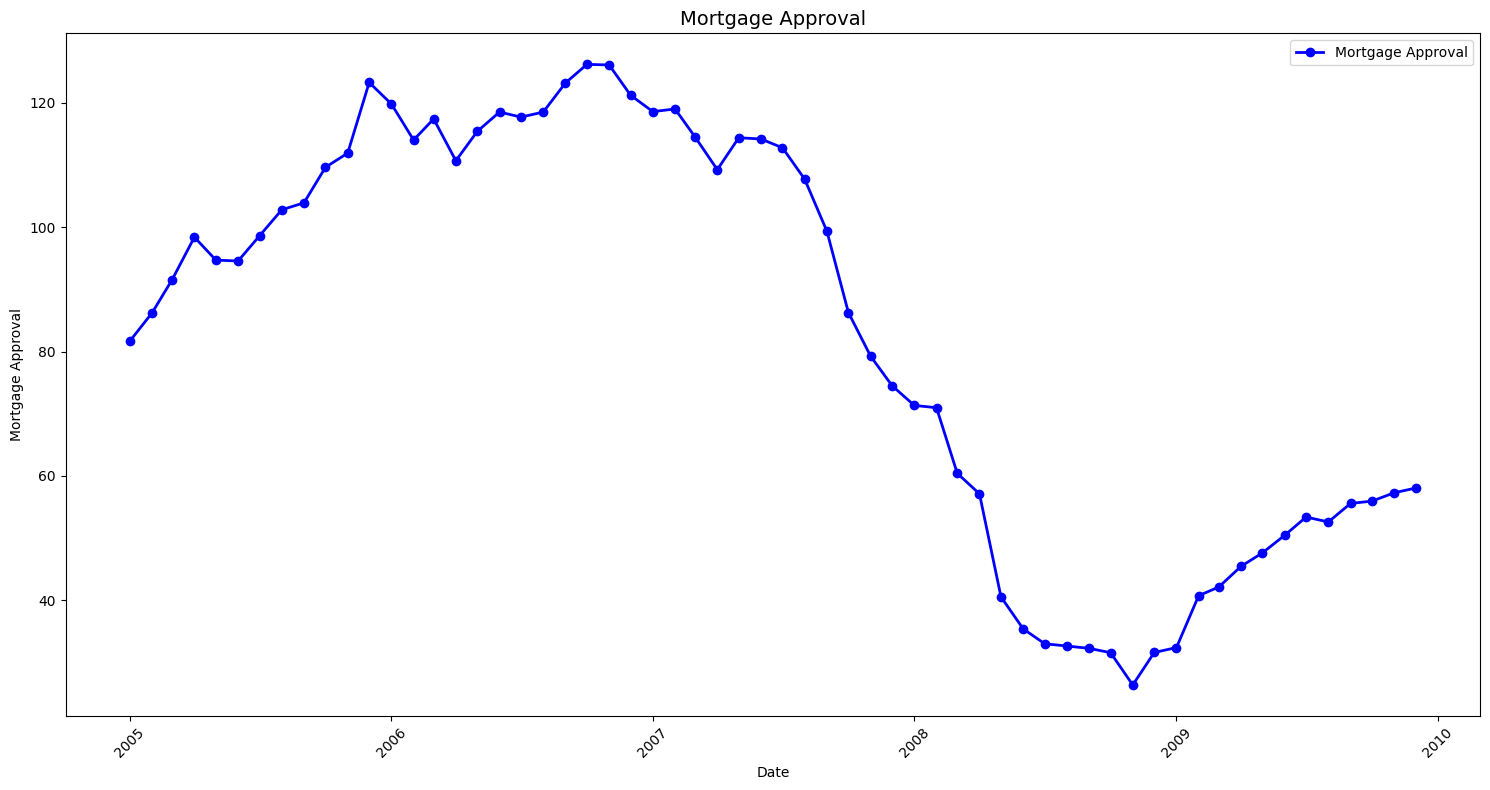

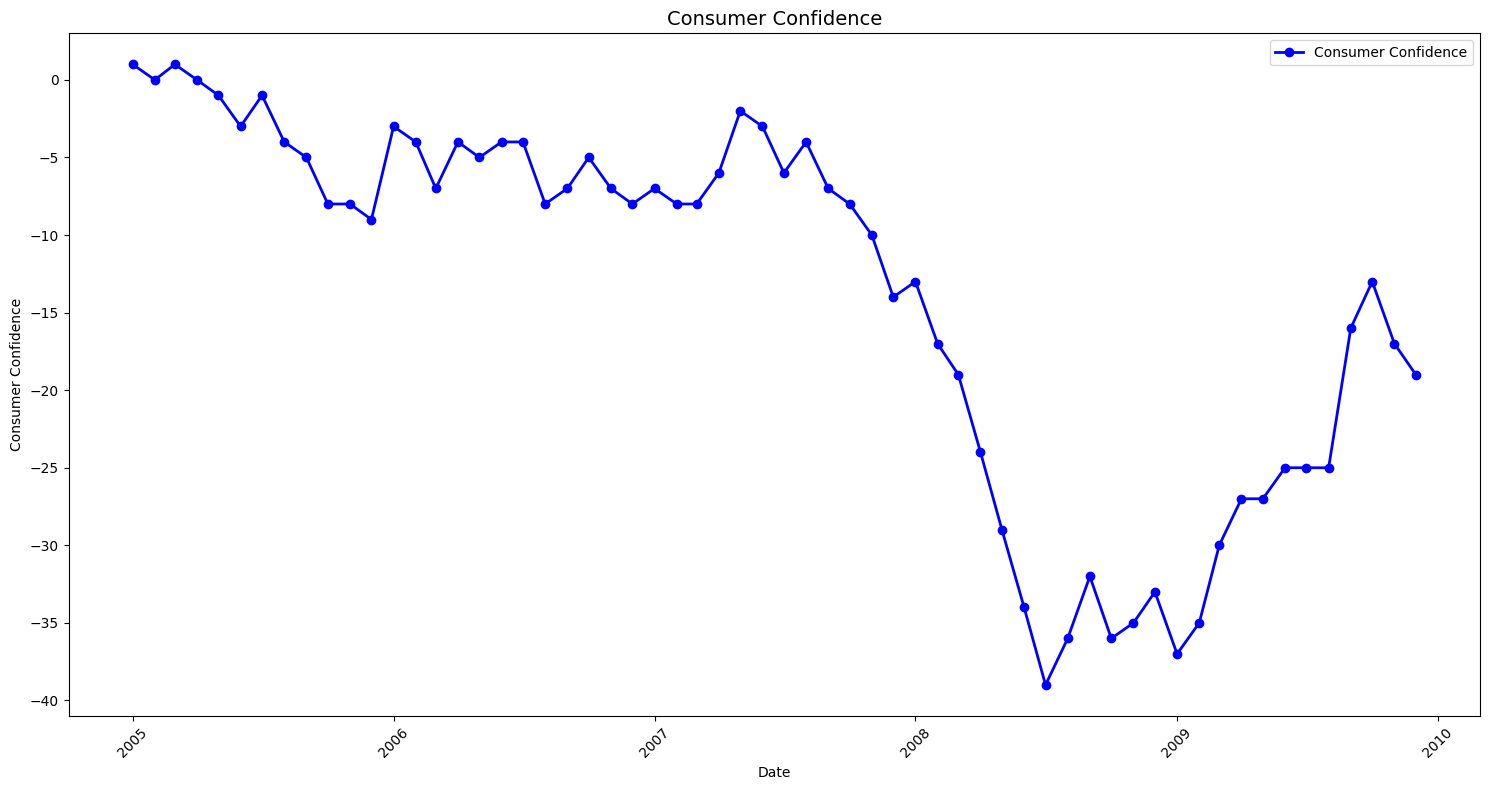

In [ ]:
crisis_year = 2008

# Loop through each DataFrame in the list
for i, df in enumerate(all_dfs[crisis_year]):
    plotting(df)


### Dataset

#### House Price Index

References: https://tradingeconomics.com/united-kingdom/housing-index

#### Mortgage Approval

References: https://tradingeconomics.com/united-kingdom/mortgage-approvals

#### Consumer Confidence

Consumer Confidence is a **measure of how optimistic or pessimistic people feel about the overall state of the economy and their personal financial situation**. It reflects people’s expectations about things like employment, income, inflation, and the general economic outlook.

When consumer confidence is **high**:

- People feel optimistic about the economy and their financial future.
They are **more likely to spend money on things like houses, cars, and vacations**.
- This can **drive economic growth** because consumer spending is a major part of the economy.

When consumer confidence is **low**:

- People feel uncertain or negative about the economy.
- They tend to **save more and spend less**, especially on big-ticket items like houses or cars.
- This can lead to **slower economic growth or even a recession** if spending drops significantly.

References: https://tradingeconomics.com/united-kingdom/consumer-confidence

#### Bank of England Interest Rate

References: https://tradingeconomics.com/united-kingdom/interest-rate

#### GBP/USD Exchange Rate

References: https://www.ons.gov.uk/economy/nationalaccounts/balanceofpayments/timeseries/auss/mret

#### GDP

References: https://www.ons.gov.uk/economy/grossdomesticproductgdp/timeseries/ihyq/qna


### Combination of multiple indicators

In [ ]:
merged_2008_df = merge_dataframes_on_date(*all_dfs[crisis_year])  # Unpack list and pass it as separate arguments
merged_2008_df = normalisation(merged_2008_df)

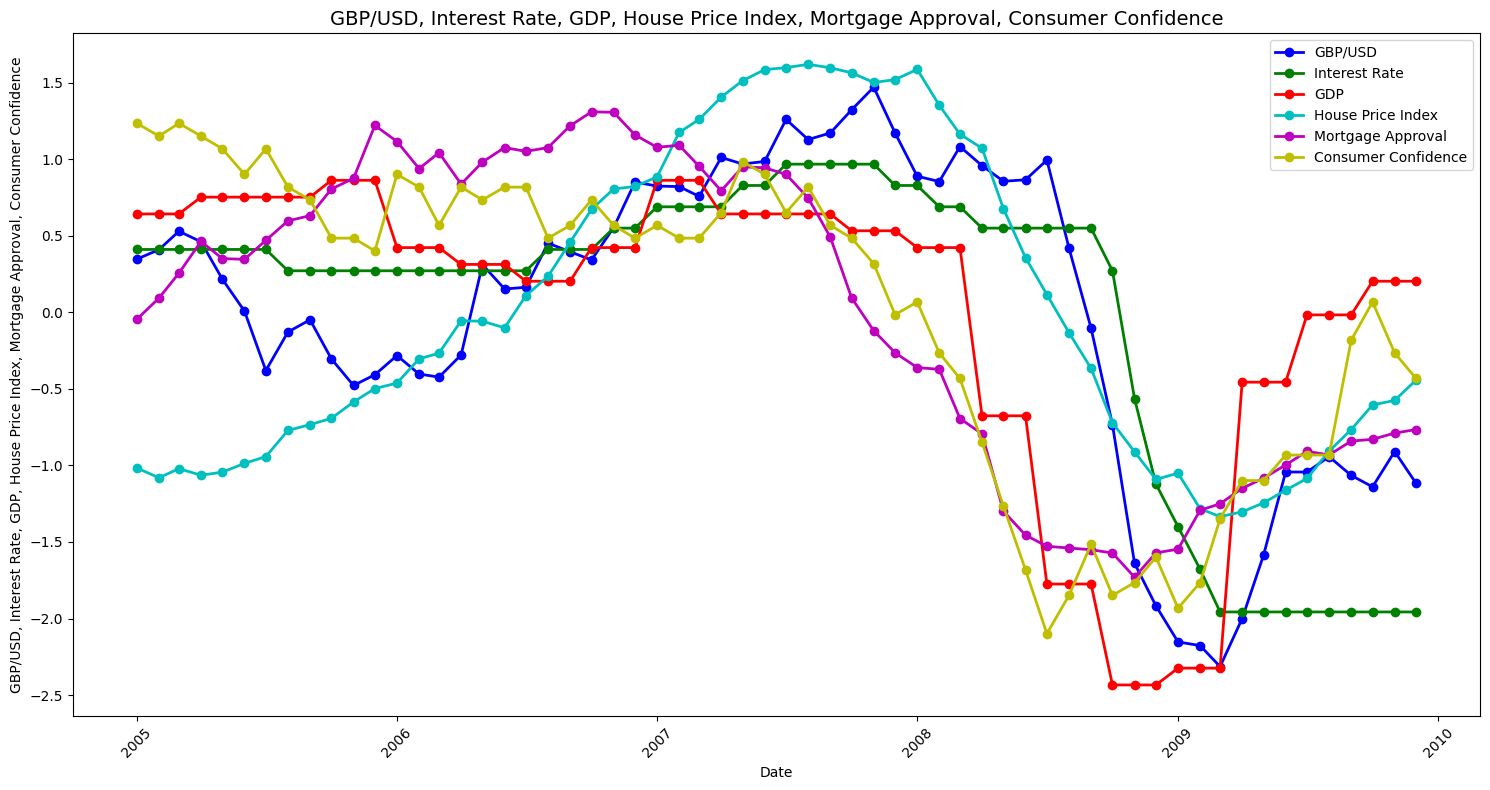

In [ ]:
plotting(merged_2008_df)

### Correlation Heatmap

A correlation heatmap is a visual representation of the correlation between multiple variables, using color-coded cells to indicate the strength and direction of their relationships.

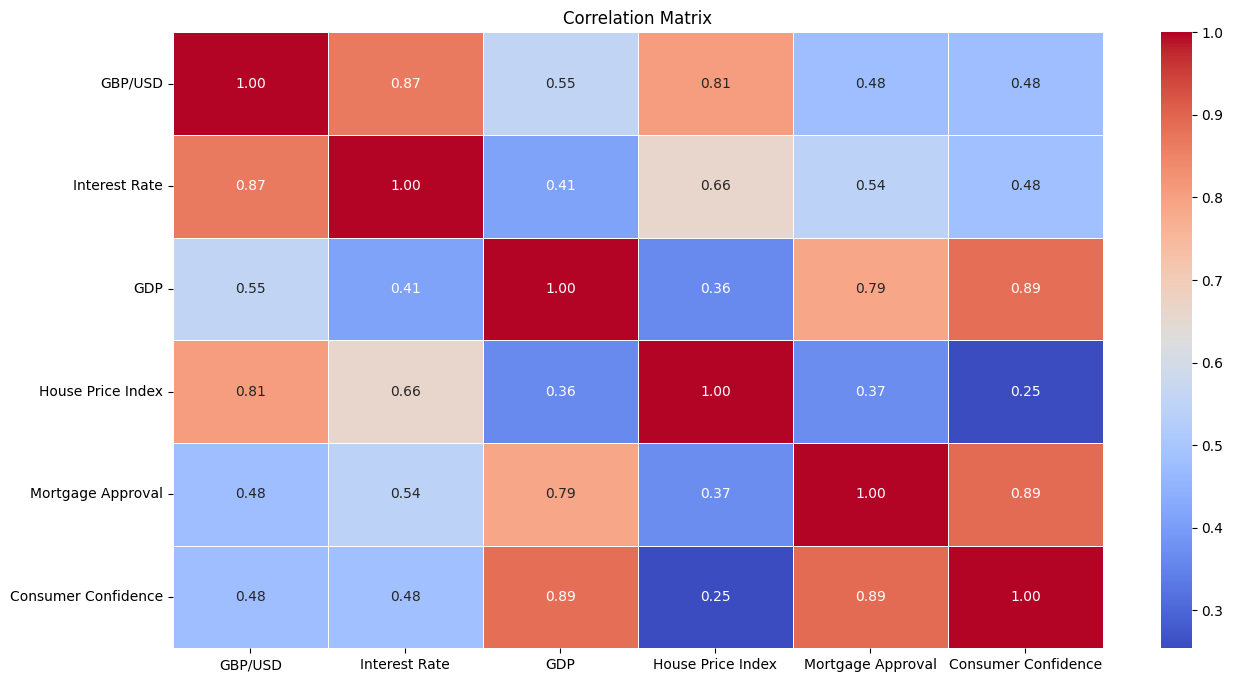

In [ ]:
plot_correlation_matrix(merged_2008_df, 'Correlation Matrix')

### Granger Causality Test

Granger causality is an econometric test used to **verify the usefulness of one variable to forecast another**.

A variable is said to:

- Granger-cause another variable if it is helpful for forecasting the other variable.
- Fail to Granger-cause if it is not helpful for forecasting the other variable.

At this point, you may be asking yourself what does it mean for a variable to be “helpful” in forecasting? In simple terms, a variable is “helpful” for forecasting, if when added to the forecast model, it reduces the forecasting error.

In the context of the vector autoregressive models, a variable fails to Granger-cause another variable if its:

Lags are not statistically significant in the equation for another variable.
Past values aren’t significant in predicting the future values of another.

Example applications of Granger causality.
- Do sunspots help forecast real GDP growth?
- Does the price of Amazon stock help forecast UPS stock prices?
- What is the functional connectivity of brain structure to underlying perception, cognition, and behavior?

Steps:
1. Meet the stationarity requirements (In time series analysis, stationarity refers to the property of a time series where its statistical properties (such as mean, variance, and autocovariance) do not change over time.) for Granger causality testing.
2. Transform data using first differences prior to testing.
3. Testing for Granger causality.

References: https://www.aptech.com/blog/introduction-to-granger-causality/

In [ ]:
granger_causality_2008 = GrangerCausalityAnalyzer(merged_2008_df, maxlag=10)
granger_causality_2008.run_workflow()

ADF Test for GBP/USD:
ADF Statistic: -3.4393694663693752
p-value: 0.009687783549075497
Critical Values: {'1%': np.float64(-3.5745892596209488), '5%': np.float64(-2.9239543084490744), '10%': np.float64(-2.6000391840277777)}
GBP/USD is stationary (reject null hypothesis)

ADF Test for Interest Rate:
ADF Statistic: -0.6724205998289455
p-value: 0.8537644899646019
Critical Values: {'1%': np.float64(-3.548493559596539), '5%': np.float64(-2.912836594776334), '10%': np.float64(-2.594129155766944)}
Interest Rate is non-stationary (fail to reject null hypothesis)

ADF Test for Differenced Interest Rate:
ADF Statistic: -3.429474857522322
p-value: 0.009994186373305838
Critical Values: {'1%': np.float64(-3.548493559596539), '5%': np.float64(-2.912836594776334), '10%': np.float64(-2.594129155766944)}
Differenced Interest Rate is stationary (reject null hypothesis)

ADF Test for GDP:
ADF Statistic: -0.706939775506767
p-value: 0.8449437811744875
Critical Values: {'1%': np.float64(-3.568485864), '5%': 

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

ssr based F test:         F=1.3408  , p=0.2579  , df_denom=28, df_num=10
ssr based chi2 test:   chi2=23.4634 , p=0.0092  , df=10
likelihood ratio test: chi2=19.1718 , p=0.0381  , df=10
parameter F test:         F=1.3408  , p=0.2579  , df_denom=28, df_num=10


Granger Causality Test: GBP/USD -> Interest Rate

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1482  , p=0.7018  , df_denom=55, df_num=1
ssr based chi2 test:   chi2=0.1562  , p=0.6926  , df=1
likelihood ratio test: chi2=0.1560  , p=0.6928  , df=1
parameter F test:         F=0.1482  , p=0.7018  , df_denom=55, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.3239  , p=0.0183  , df_denom=52, df_num=2
ssr based chi2 test:   chi2=9.4794  , p=0.0087  , df=2
likelihood ratio test: chi2=8.7689  , p=0.0125  , df=2
parameter F test:         F=4.3239  , p=0.0183  , df_denom=52, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8692  , p=0.014

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

ssr based F test:         F=1.4096  , p=0.2270  , df_denom=28, df_num=10
ssr based chi2 test:   chi2=24.6674 , p=0.0060  , df=10
likelihood ratio test: chi2=19.9792 , p=0.0294  , df=10
parameter F test:         F=1.4096  , p=0.2270  , df_denom=28, df_num=10


Granger Causality Test: House Price Index -> GDP

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3400  , p=0.0730  , df_denom=55, df_num=1
ssr based chi2 test:   chi2=3.5222  , p=0.0606  , df=1
likelihood ratio test: chi2=3.4194  , p=0.0644  , df=1
parameter F test:         F=3.3400  , p=0.0730  , df_denom=55, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1975  , p=0.0204  , df_denom=52, df_num=2
ssr based chi2 test:   chi2=9.2022  , p=0.0100  , df=2
likelihood ratio test: chi2=8.5307  , p=0.0140  , df=2
parameter F test:         F=4.1975  , p=0.0204  , df_denom=52, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3133  , p=0.280

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

ssr based F test:         F=1.7979  , p=0.1336  , df_denom=43, df_num=5
ssr based chi2 test:   chi2=11.2892 , p=0.0459  , df=5
likelihood ratio test: chi2=10.2515 , p=0.0684  , df=5
parameter F test:         F=1.7979  , p=0.1336  , df_denom=43, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.2288  , p=0.3122  , df_denom=40, df_num=6
ssr based chi2 test:   chi2=9.7688  , p=0.1347  , df=6
likelihood ratio test: chi2=8.9658  , p=0.1755  , df=6
parameter F test:         F=1.2288  , p=0.3122  , df_denom=40, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.1047  , p=0.3807  , df_denom=37, df_num=7
ssr based chi2 test:   chi2=10.8676 , p=0.1445  , df=7
likelihood ratio test: chi2=9.8689  , p=0.1961  , df=7
parameter F test:         F=1.1047  , p=0.3807  , df_denom=37, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.0479  , p=0.4212  , df_denom=34, df_num=8
ssr based chi2 test:   chi2=

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


likelihood ratio test: chi2=13.3550 , p=0.1472  , df=9
parameter F test:         F=1.0546  , p=0.4218  , df_denom=31, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0546  , p=0.4270  , df_denom=28, df_num=10
ssr based chi2 test:   chi2=18.4562 , p=0.0477  , df=10
likelihood ratio test: chi2=15.6633 , p=0.1097  , df=10
parameter F test:         F=1.0546  , p=0.4270  , df_denom=28, df_num=10


Granger Causality Test: House Price Index -> Mortgage Approval

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.8017 , p=0.0001  , df_denom=55, df_num=1
ssr based chi2 test:   chi2=17.7182 , p=0.0000  , df=1
likelihood ratio test: chi2=15.4614 , p=0.0001  , df=1
parameter F test:         F=16.8017 , p=0.0001  , df_denom=55, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.2984 , p=0.0002  , df_denom=52, df_num=2
ssr based chi2 test:   chi2=22.5773 , p=0.0000  , df=2
likelihood ratio test: chi2=19

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


### Lasso Regression

LASSO regression is a type of linear regression that helps pick out the most important factors in a dataset. It does this by shrinking the impact of less important features and even removing some entirely. This makes the model simpler, easier to understand, and less likely to overfit the data.  

Using **GDP as an indicator** to analyse the crisis, LASSO regression helps by identifying the most important factors that influenced GDP during that period.  

Since many economic variables can affect GDP, LASSO helps by filtering out the less relevant ones and keeping only the key drivers. This makes the analysis more focused and prevents your model from being overwhelmed by unnecessary data.  

In simple terms, LASSO tells you:  
"Out of all the economic factors you considered, these are the ones that truly impacted GDP during the crisis."

This is especially useful when dealing with many overlapping economic indicators, as it reduces noise and improves prediction accuracy.



Best Alpha: 0.020050060120240482
Selected Features by LASSO: ['GBP/USD', 'Interest Rate', 'House Price Index', 'Consumer Confidence']


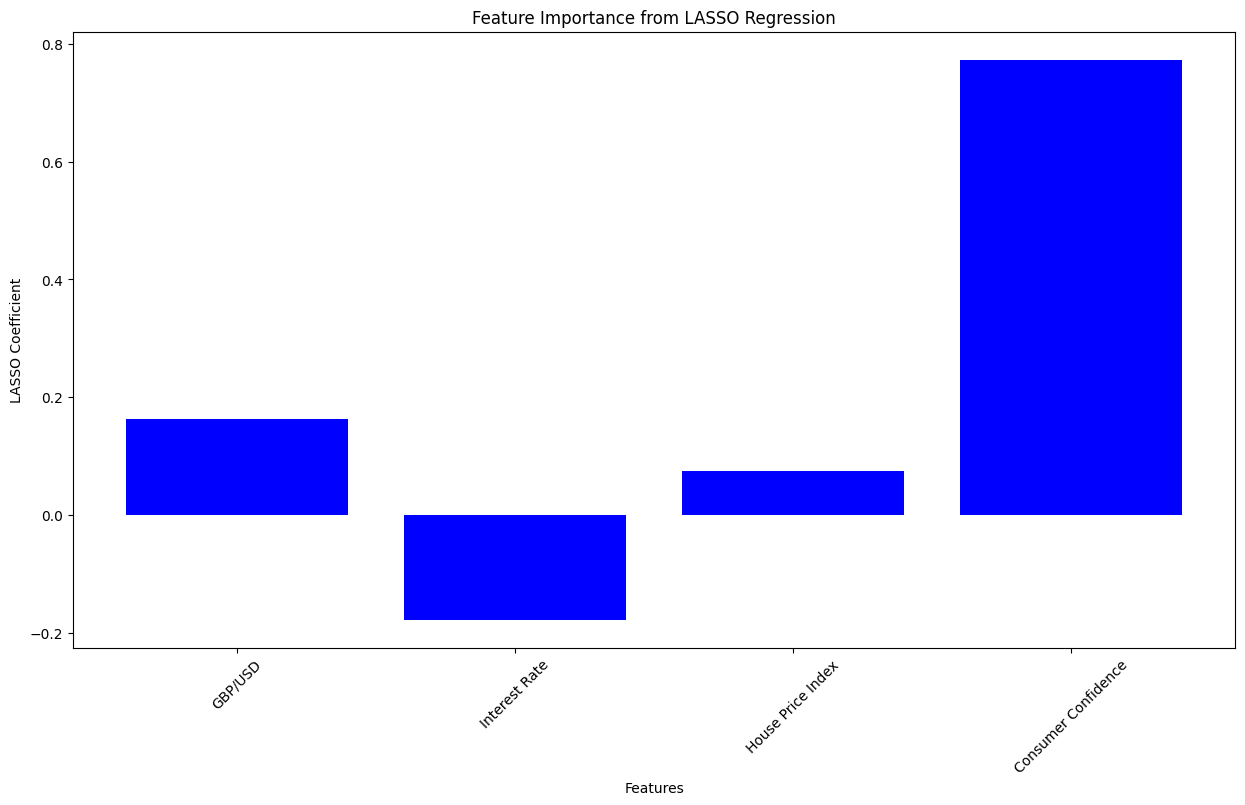

In [ ]:
selected_features = lasso_feature_selection(merged_2008_df, "GDP")

### Multiple Linear Regression

Random Residual Plot (Good Fit):

- Residuals are evenly spread out around the horizontal line at 0, without any obvious pattern.


Non-Random Residual Plot (Bad Fit):

- Residuals show a curve or trend, indicating that the linear model is not capturing some important relationship.

Finding best lags...
Best lags: {'GBP/USD': 4, 'Interest Rate': 4, 'House Price Index': 6, 'Consumer Confidence': 2}
Creating lagged dataset...
Training model...
Final Model MSE: 0.13642539585949298


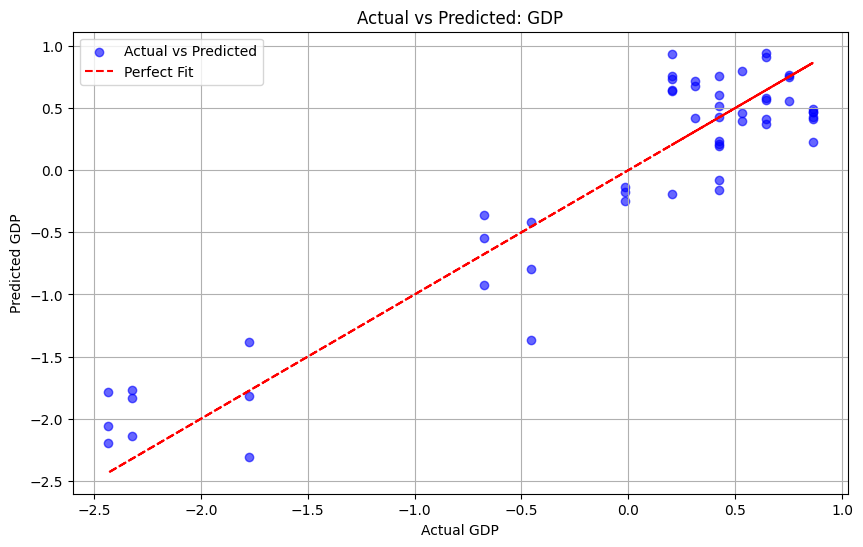

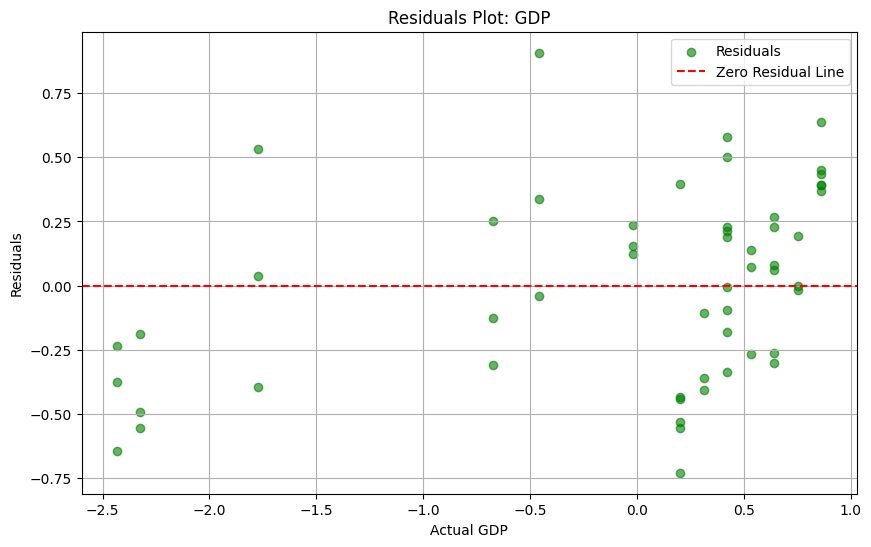

Optimal Lags: {'GBP/USD': 4, 'Interest Rate': 4, 'House Price Index': 6, 'Consumer Confidence': 2}
Model MSE: 0.13642539585949298


In [ ]:
# Initialize model
ts_model = TimeSeriesRegression(merged_2008_df, selected_features, 'GDP', max_lag=6)

# Run the full process
ts_model.run()

# Access results
print("Optimal Lags:", ts_model.best_lags)
print("Model MSE:", ts_model.mse)

#### 2008 Global Financial Crisis Timeline

References:

- https://express.adobe.com/page/DAlRb7HdWiHqA/

- https://www.leading.uk.com/what-caused-the-2008-financial-crisis-in-the-united-kingdom/

**September 2007**

In the years leading up to the financial crisis, **the British bank Northern Rock** had expanded aggressively, turning to international money markets to fund its rapid growth.

However, when problems in the **US sub-prime mortgage market (US banks gave out risky loans to people with poor credit.)** These high-risk loans created a **housing bubble** (Many of these loans were used to buy homes—leading to **increased demand in the housing market.** As more people bought homes, **housing prices began to rise**, creating a "bubble" in the housing market (a situation where prices **grow beyond their true value**, driven by speculative buying).), and when people couldn’t pay back their loans the **bubble burst** (As borrowers defaulted, **more homes were foreclosed (taken by banks)**. Foreclosures flooded the market, **driving home prices down**. The housing bubble burst—prices fell dramatically, and **people who had bought homes at the peak found that their properties were worth much less than what they owed on them.**), causing widespread financial chaos.

This chaos quickly spread to the UK because the global financial markets are interconnected. British banks had invested heavily in the US housing market through complex financial products like mortgage-backed securities (MBS) and collateralised debt obligations (CDOs). When these investments plummeted in value, it had a massive impact on the UK financial system.) started to spread to Europe in the summer of 2007, this source of financing dried up. Northern Rock was left facing a severe liquidity crisis.

On 14 September, Northern Rock’s perilous position was made public. Despite liquidity support from the Bank of England, a run on Northern Rock was triggered - **the first UK bank run (people panicked and rushed to take their money out) for over 140 years**. In response, **the Chancellor, Alistair Darling, announced that the Government would guarantee all existing deposits on 17 September.**

At the time of Northern Rock’s failure the legal framework for dealing with failing banks was deficient in two important ways. **Any deposits over £2,000 would not be fully reimbursed (After that, you’d only get 90% of the next £33,000. If you had more than that, you could lose some of your savings.)**, and if Northern Rock were to be declared insolvent and put into administration, **deposits would have been frozen**, with a long wait before even partial reimbursement.

**Since the crisis...**

**Deposits are now fully guaranteed up to a limit of £85,000 through the Financial Services Compensation Scheme (FSCS).**

The UK now also has a **comprehensive resolution framework that allows banks to fail in an orderly manner.** This regime gives the authorities a variety of options for dealing with a failing or failed bank quickly and fairly, **without using taxpayers’ money for a bailout.**

**7 September 2008**

**Fannie and Freddie (US)**

In the US, two huge mortgage finance agencies, Fannie Mae (Federal National Mortgage Association) and Freddie Mac (Federal Home Loan Mortgage Corporation), were taken over by the US Government. **The $187.5 billion bailout was one of the largest financial rescues in U.S. history. (This bailout was meant to stabilize the institutions and protect the broader economy, as Fannie and Freddie were central to the mortgage system in the U.S.)**

Fannie Mae and Freddie Mac’s main business was packaging up home loans into products called **mortgage-backed securities (Their main business was to buy home loans from banks and lenders. After buying these loans, they would bundle them together into financial products called mortgage-backed securities (MBS).)** that were then sold on to investors. As the US housing market steadily weakened and then collapsed, so did Fannie and Freddie.

The scale of the bailout immediately heightened concerns about the stability of the entire financial system, and institutions already known to be vulnerable came under increased scrutiny. One of these was the leading US investment bank Lehman Brothers.

**Since the crisis...**

The financial crisis revealed how a seemingly isolated issue in one country could have far-reaching consequences. The interconnectedness of global finance meant that the UK financial system had become dangerously exposed to the fall-out from the US sub-prime mortgage market.

Before the crisis, oversight of the UK financial system was shared between the Bank of England, the FSA and the Treasury. This left no authority with clear responsibility for monitoring how risks were building up across the financial system.

Regulatory failures and lax oversight were big factors in the crisis. The **Financial Services Authority (FSA), which was supposed to keep an eye on banks in the UK, didn’t see the risks building up.** They were more reactive than proactive, letting risky behaviours grow unchecked.

Also, because financial markets are so global, no single regulator has the full picture of the growing risks. The “light-touch” approach of that time, which involved minimal intervention, just wasn’t enough to prevent the crisis.

Credit rating agencies, which were supposed to judge how risky financial products were, played a part in the crisis by giving high ratings to complex and risky investments. These agencies often had conflicts of interest because they were paid by the same companies whose products they were rating. This misled many investors, including UK banks, into thinking these products were safer than they actually were.

When the risks of these products came to light, their value crashed, causing huge losses for banks and investors all around the world.

In response, the Bank of England’s **Financial Policy Committee (FPC)** was established in 2013. The FPC is charged with **spotting risks as they emerge and making sure the financial system is resilient enough to support the economy if the risks crystallise.**

**10-13 September 2008**

**Lehman Brothers on the brink**

Lehman Brothers had been heavily involved in selling **collateralised debt obligations (CDOs) – complex financial products based on mortgage-backed securities**. This left the bank dangerously exposed to the US sub-prime mortgage crisis, and on 10 September Lehman Brothers announced Q3 net losses of 3.9 billion, on top of a Q2 loss of 2.8 billion.

On 13 September, **the president of the Federal Reserve Bank of New York, Timothy Geithner, convened a meeting of senior bankers to discuss Lehman’s future.** **The British bank Barclays emerged as a possible buyer, but concerns over the deal caused Barclays to walk away.**

While one of Lehman Brothers' rivals, fellow investment bank Bear Stearns, had been bailed out earlier in the year (14 March 2008), it became increasingly clear that Lehman Brothers would be allowed to fail.

**Since the crisis...**

Lehman Brothers was part of the **‘shadow banking’** or ‘market-based finance system’, defined by the Financial Stability Board as **‘entities and activities structured outside the regular banking system that perform bank-like activities'.** The shadow banking system grew rapidly in the years leading up to the crisis, and was not subject to the same level of oversight as the regular banking system.

Shadow banking plays an important role in the financial system by **offering alternative sources of credit.** But it also allowed banks to move certain risky activities off their balance sheets, including sub-prime mortgage-backed securities and collateralised debt obligations.

The crisis showed that shadow banking risks can easily spill over into the regular banking system. Consequently, shadow banking has been a major focus of reform: led by the FSB, regulators are establishing system-wide oversight to assess financial stability risks from shadow banking. Risky off-balance sheet activities are **now regulated far more strictly, having shrunk by 40% since 2007.**

**15 September 2008**

**Lehman Brothers fails**

A day of chaos on Wall Street quickly spread round the world. After attempted rescue deals fell through, Lehman Brothers filed for bankruptcy in the early hours of the morning.

Like Lehman Brothers, the **US investment bank Merrill Lynch** had been heavily involved in selling complex financial products like CDOs. By mid-September it too was **close to collapse**, having lost 19.2 billion between July 2007 and July 2008. **Bank of America stepped in and agreed to buy Merrill Lynch for $50 billion, saving it from bankruptcy.**

On the same day, **credit rating agencies downgraded insurance giant American International Group (AIG)**, sparking a liquidity crisis. AIG had been **insuring banks against losses on their CDOs by using a kind of credit protection known as credit default swaps**, and they ran into acute financial difficulty as these losses began to mount rapidly.

**Since the crisis...**

The crisis highlighted numerous weaknesses in the international regulatory framework. Since 2008, new rules have been implemented that aim to correct these deficiencies.

**Banks have to hold more and better quality capital** to provide a more effective buffer against losses. Capital requirements for large banks are **ten times higher** than before the crisis.

Leverage refers to how much debt a bank takes on compared to its capital. In simple terms, it's the amount of borrowing a bank does to increase the size of its investments.

Excessive leverage played a significant role in the crisis because **banks borrowed too much and relied on debt**, which made them vulnerable when their investments lost value.

In essence, the **leverage ratio limits the amount of debt a bank can take on and ensures that banks have enough equity (their own money) to cover any potential losses, reducing the risk of financial instability.**

**Liquidity refers to the ability of a bank to meet its short-term financial obligations (like paying off debts) without facing difficulty.**

During the financial crisis, many banks faced liquidity problems because they had **invested too heavily in illiquid assets** (such as mortgage-backed securities) that **couldn’t be easily sold to raise cash.**

To prevent such liquidity crises in the future, banks are now required to **hold more liquid assets**. This means they **must have enough readily available cash or assets that can be easily sold to meet their obligations in times of stress.**

The new rules include much tougher liquidity requirements, ensuring that banks are better prepared to weather financial storms and avoid a collapse due to a shortage of cash or assets.

**16 September 2008**

**AIG rescued**

AIG’s liquidity crisis intensified, and at 9pm EDT the Federal Reserve Board announced that the **US Government had stepped in to bail out the insurance company.** The immediate support was an 85 billion credit facility. By March 2009 the US Treasury and Federal Reserve had committed $182.3 billion to the rescue.

The authorities had decided that AIG was too big and too interconnected to fail. As of 30 June 2008 the company’s consolidated total assets totalled more than $1 trillion and it was the largest provider of conventional insurance in the world.

AIG also sat at the centre of a dense web of financial contracts: had it been allowed to go bankrupt, AIG could have **taken down many of the banks it had sold credit protection to.**

**Since the crisis...**

Since the crisis the **Financial Stability Board (FSB)** has created a framework for **identifying Systemically Important Financial Institutions (SIFIs) - These are banks and insurance companies whose size, complexity and interconnectedness would cause severe problems for the global economy if they failed.**

SIFIs are now subject to more stringent supervision and extra requirements: the bigger the bank and the riskier its business, the more capital it must hold against possible losses. Recognising that SIFIs operate across multiple countries, the FSB has focused on improving cross-border cooperation when designing and implementing resolution plans for failing banks.

The FSB has also led improvements to the use of credit default swaps. These contracts must be more transparent, and many are now traded through central counterparties. This has reduced the complexity of the interconnected network through which contagion spread in 2008.

**17 September 2008**

**Liquidity squeeze (meaning banks were running out of ready cash and couldn’t easily access funds to keep operating smoothly.) intensifies**

As liquidity became an ever-increasing concern in the wake of Lehman Brothers’ bankruptcy, we extended our **Special Liquidity Scheme**.

The SLS allowed banks to **swap high-quality but illiquid assets for UK Treasury bills**. Because Treasury bills are a **liquid asset**, banks were able to **use them as collateral to borrow cash.**

**Since the crisis...**

Lack of liquidity and a reliance on short-term funding contributed to the severity of the crisis. Post-crisis reforms have focused on improving the stability of banks’ funding and increasing their ability to cope with periods of stress.

In order to enhance short-term resilience, **banks must now hold enough highly liquid assets to be able to withstand a 30-day liquidity stress.** As a result, UK banks’ buffers of liquid assets have **increased by over 40% since 2010, now standing at over £700bn.**

The new rules also require banks to balance short-term and long-term funding. Short-term funding often dries up suddenly in times of uncertainty. By making banks less dependent on it, they are in a better position to withstand unexpected shocks.

**18 September 2008**

**Lloyds TSB announces HBOS (Halifax Bank of Scotland) merger**

A day after its share price fluctuated wildly, it was announced that HBOS, Britain’s sixth-biggest bank and largest mortgage provider, would merge with Lloyds TSB, itself the fifth-biggest bank in Britain.

The fallout from Lehman Brothers meant that already vulnerable banks like HBOS became even weaker as the crisis continued to intensify.

**Since the crisis...**

The collapse of HBOS revealed problems with the way banks were supervised in the UK. Prior to the crisis, both prudential and conduct regulation were the responsibility of the Financial Services Authority (FSA). This left the FSA with too many objectives to juggle, and in 2013 it was abolished and its **responsibilities split between the newly created Prudential Regulation Authority of the Bank of England (PRA) and the Financial Conduct Authority (FCA).**

The FSA failed to ensure that adequate resources were devoted to the supervision of large systemically important firms like HBOS. Now, the PRA has a judgement-based supervisory approach, where the amount of resource dedicated to a firm is proportionate to the risk it poses to the financial system.

Another contributing factor to HBOS’s demise was that its board and senior management failed to set an appropriate strategy for the bank or challenge its flawed business model. In the aftermath of the crisis it proved difficult to hold the executives of failed banks to account. To prevent this from happening again, we **launched the Senior Managers and Certification Regime in 2016.** The SM&CR **requires firms to allocate clear roles and responsibilities to senior individuals like the CEO and Chair, making it easier to establish accountability if things go wrong.**

**29 September 2008**

**Rescue plans**

In the UK, the **Yorkshire bank Bradford & Bingley** was nationalised. The **Government took control of the bank’s mortgage and loan books**, while its **branches and deposits were sold to the Spanish banking group Santander.**

Bradford & Bingley had been struggling to convince the market of its viability in the months leading up to Lehman Brothers’ collapse. Its rapid expansion into **buy-to-let mortgages** left Bradford & Bingley vulnerable to a downturn in the housing market. And as short-term funding dried up after Lehman Brothers went bankrupt, Bradford & Bingley’s ability to support itself also evaporated.

Meanwhile in the **US, the government’s plan to stabilise the financial system by purchasing $700 billion of ‘troubled assets’ was rejected by Congress.** The Dow Jones stock market index suffered its largest single-day point drop following the unsuccessful vote. The **Troubled Asset Relief Program was eventually voted though on 3rd October.**

**Since the crisis...**

Faced with Bradford & Bingley’s collapse, the UK authorities now had the option of nationalising the bank in an orderly fashion. Following the chaotic run on Northern Rock twelve months before, **Parliament had passed the Banking (Special Provisions) Act 2008 (temporary fix)  in February 2008**, which allowed the **UK Government to nationalise UK banks under emergency circumstances.**

The Act has now been **replaced** by a comprehensive resolution regime, which gives the regulator several options when faced with a failing or failed bank. These include **‘bail-in’**, a tool that **enables losses to be imposed on the failed bank’s shareholders and other creditors, rather than the government.** Bail-in ensures that **investors bear losses** rather than the taxpayer.

**1-7 October 2008**

**HBOS and RBS (Royal Bank of Scotland) rescued**

The British banks HBOS and RBS were in dire financial straits, and Bank of England stepped in to provide emergency liquidity. This peaked at £25.4 billion for HBOS and £36.6 billion for RBS.

To maintain financial stability, this assistance was **not made public (acoid panic)** **until November 2009 (immediate danger had passed)**, when the then Governor of the Bank of England, Mervyn King, disclosed details of the operation to the Treasury Committee.

**Since the crisis...**

Bank of England's arrangements for providing liquidity in times of stress are now more formally organised. We have worked with banks to ensure they have appropriate collateral ready should they need to borrow from us – allowing them to access up to £320 billion in additional liquidity. We consider it important to retain the ability to **delay disclosure of certain forms of liquidity assistance.** This is because prematurely revealing that a bank needs liquidity assistance can increase financial instability rather than avoid it, for example by **causing a bank run.**

When RBS failed, the authorities had no way of protecting the bank’s retail depositors and ensuring that critical services like payments continued smoothly without rescuing the whole bank. **To make sure that banks can fail without disrupting banking services to individuals and small businesses, from 2019 large UK banks must separate core retail banking services from their riskier investment and international banking activities. This is known as ring-fencing.**

Remuneration rules have also been progressively strengthened to better align pay with performance and to discourage excessive risk-taking and misconduct.**

**8 October 2008**

**System-wide support**

It was becoming apparent that the chaos unleashed by Lehman Brothers’ demise could not be calmed by isolated interventions. Instead, a coordinated, system-wide response was needed.

Accordingly, the UK authorities announced a comprehensive financial support package aimed at recapitalising the banks and providing sufficient liquidity to the financial system. In the case of the most vulnerable banks, this meant part-nationalisation. As part of this, eight major UK banks committed to increasing their capital, allowing them to absorb losses more effectively in the future.

On the same day, the **Icelandic bank Landsbanki collapsed**, putting the deposits of its many UK customers in danger. Despite operating in the UK, Landsbanki was regulated by the Icelandic authorities. When the **Icelandic government refused to guarantee UK deposits**, the **Chancellor, Alistair Darling, moved quickly to freeze Landsbanki’s assets in the UK to protect British deposit-holders. (prevent funds from being moved out of the UK before depositors could be compensated.)**

**Since the crisis...**

Since 2014 we have **carried out stress tests on the UK’s banks.** These involve looking at **a range of “what if” scenarios**, such as a sudden downturn in economic conditions. Stress tests allow us to **assess banks’ resilience and make sure they have enough capital to withstand shocks, and to support the economy if a stress does materialise.**


The drastic action taken by the UK government to protect UK deposits in Icelandic banks showed a clear need for a more cooperative approach to **supervising international banks**. The **PRA** now requires a clear split of **supervisory responsibilities for branches of non-EU banks to be agreed with the home state supervisor.** Only subsidiaries of non-EU banks are allowed to hold significant amounts of retail deposits. And if an international bank fails, its resolution plan must minimise risks to the UK’s financial stability.

**10 October 2008**

**International coordination**

By October it was clear that what had started as a seemingly self-contained problem in the US sub-prime mortgage market had developed into a global crisis that required a global response.

After a **meeting of Finance Ministers and Central Bank Governors in Washington DC** on 10 October, the G7 (a group of the world’s largest economies (Canada, France, Germany, Italy, Japan, the UK, and the US) agreed to a five-point Plan of Action to stabilise financial markets and restore the flow of credit to support economic growth.

**The Five-Point Plan of Action**
The G7 agreed on five key actions to stabilise the global financial system:

**Protect major financial institutions:**

- Prevent systemically important banks (those “too big to fail”) from collapsing.
- Governments pledged to provide emergency funding if needed.

**Unfreeze credit markets:**

- Banks had stopped lending, even to each other.
- Central banks promised to pump liquidity into the system to restart the flow of credit.

**Safeguard deposits and strengthen confidence:**

- Governments reassured the public that deposits were safe by strengthening deposit guarantees.
- This aimed to prevent further “bank runs” (where people rush to withdraw their money).

**Ensure banks could raise capital:**

- Banks were required to boost their capital reserves to absorb future losses.
- Governments supported this by recapitalising banks and encouraging private investment.

**Improve international cooperation:**

- Countries agreed to work together to manage the crisis, share information, and avoid conflicting actions.
- The crisis had shown that in a globally interconnected system, no country could solve this alone.


**Since the crisis...**

Since the crisis, international cooperation has increased dramatically. Founded in 2009, the Financial Stability Board is charged with promoting and monitoring global financial stability. The FSB has spearheaded international reforms and tracks implementation of new international standards.

The FSB comprises senior policy makers from finance ministries, central banks, and supervisory and regulatory authorities, drawn from the G20 countries, other significant financial centres and international bodies. The FSB’s policies and recommendations are not legally binding. Instead the FSB acts as a coordinating body, with its members committing to implement its standards at national level.

# 2022 Energy & Inflation Crisis


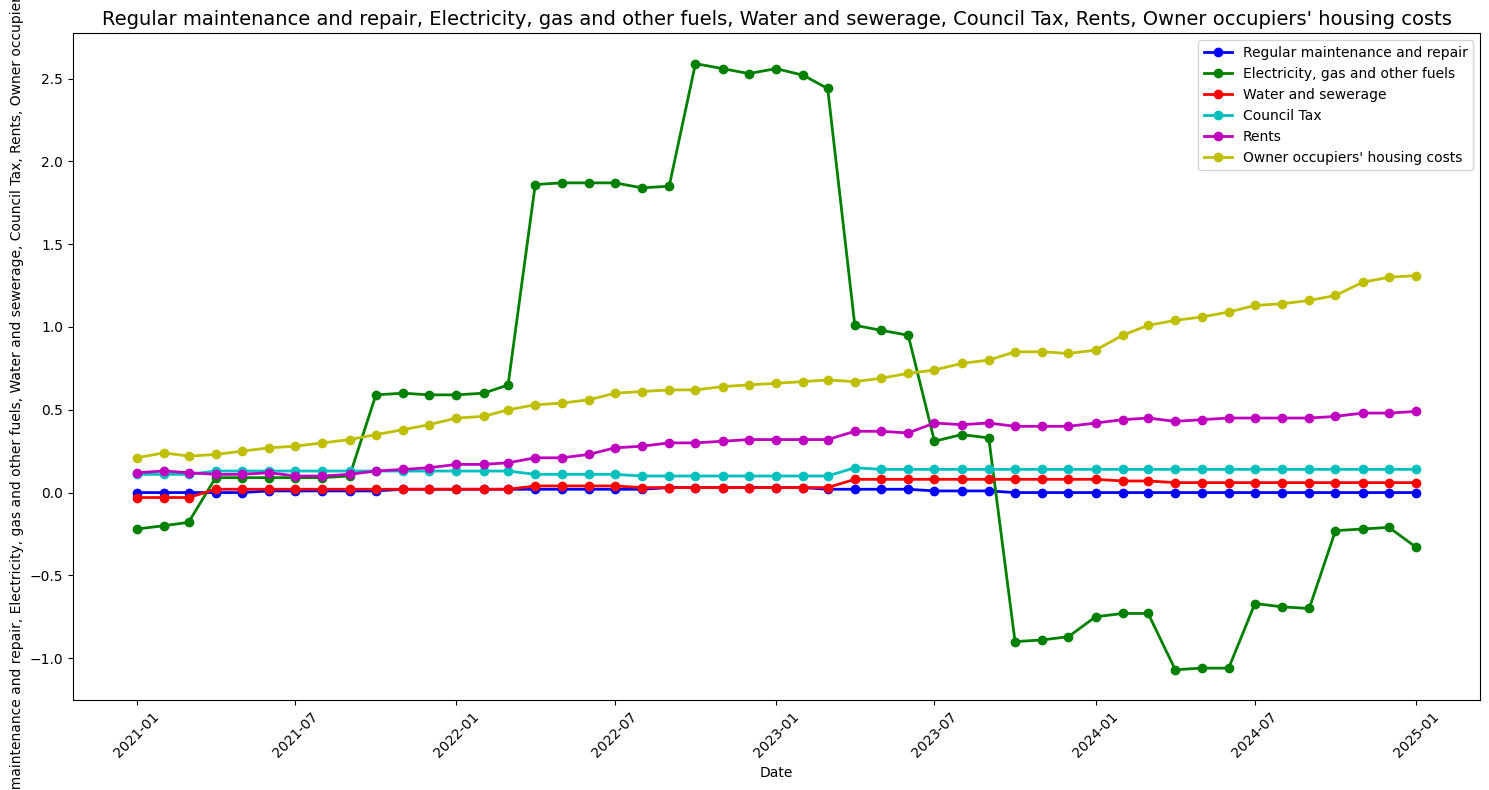

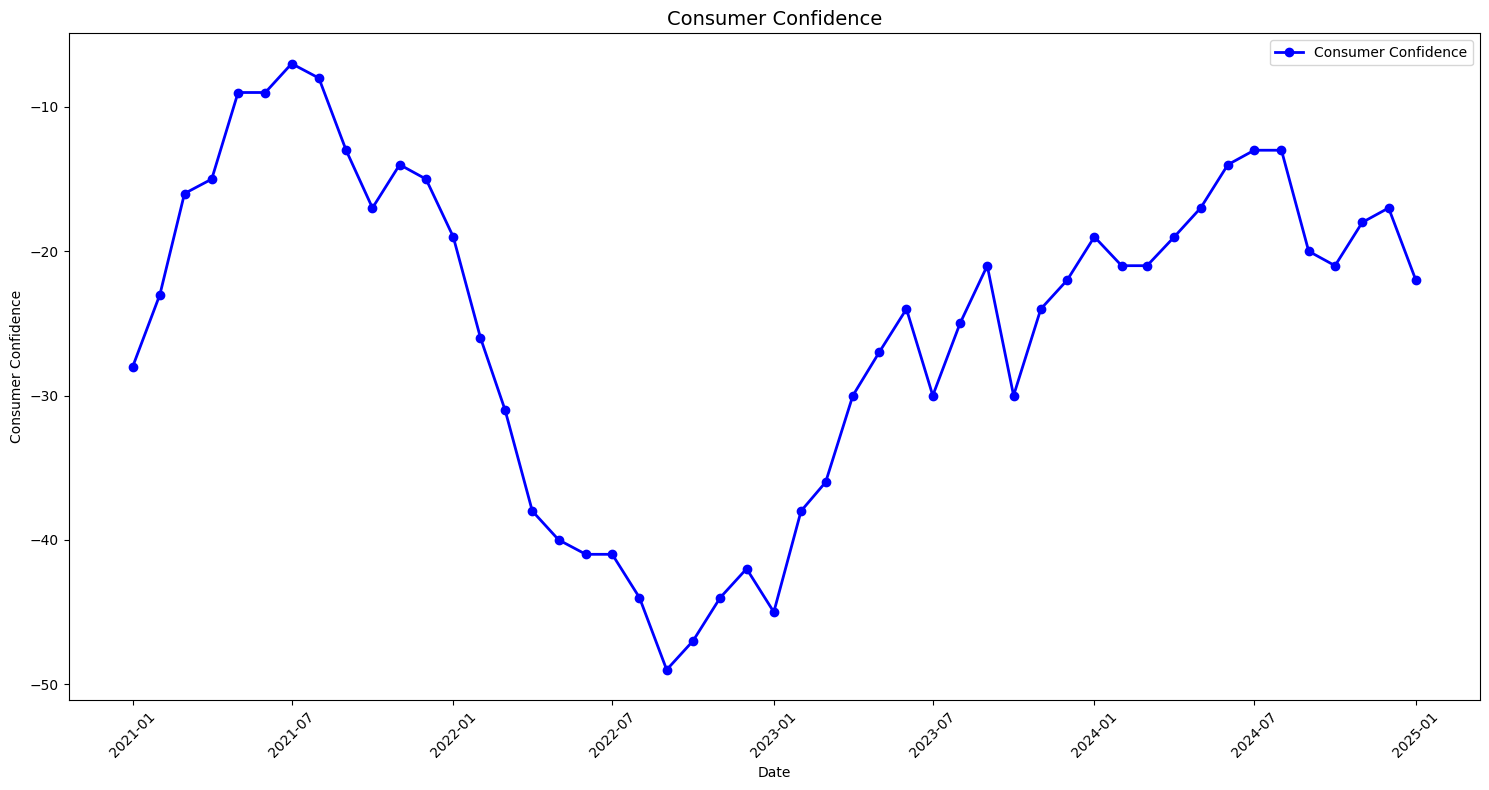

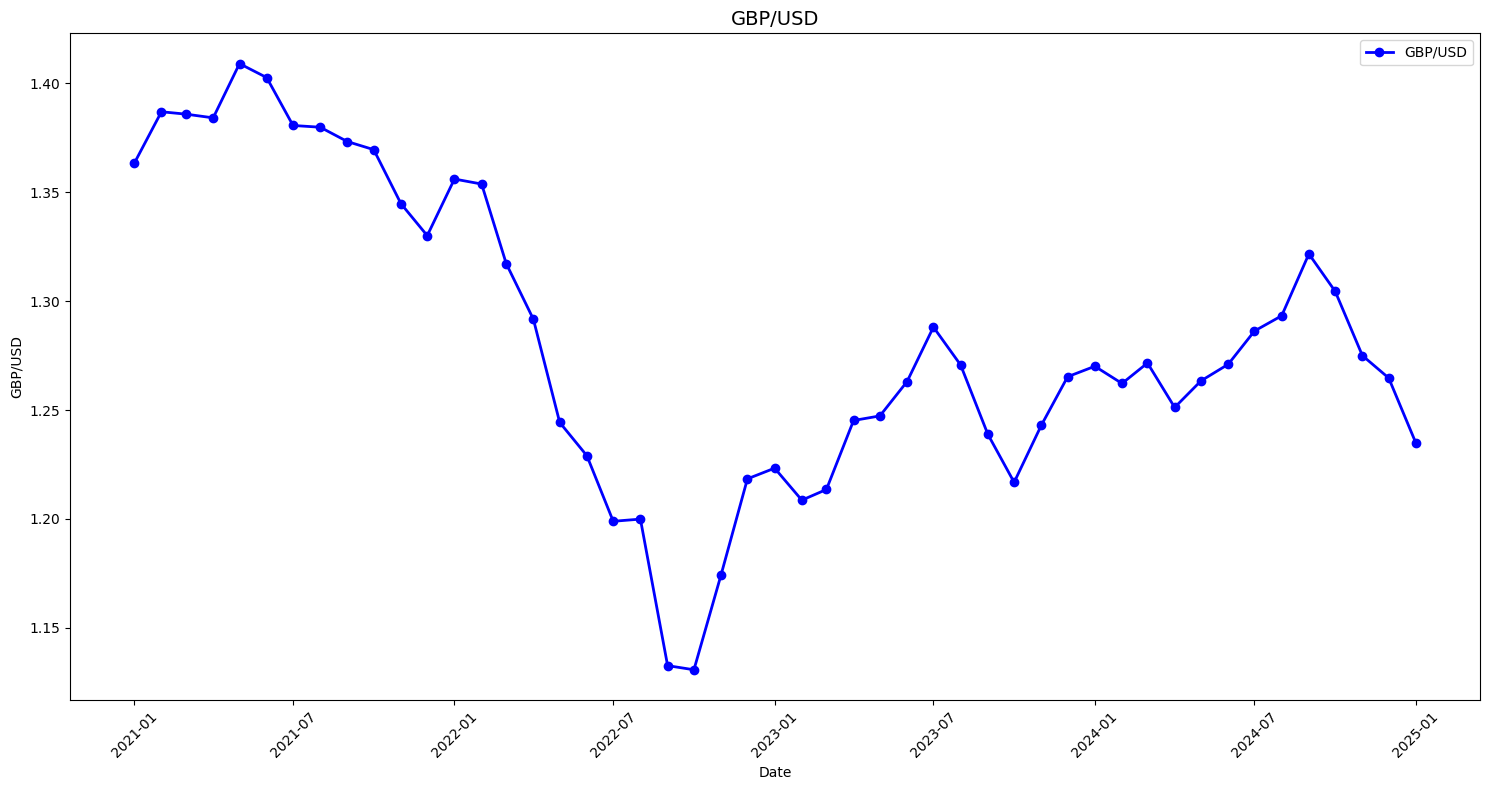

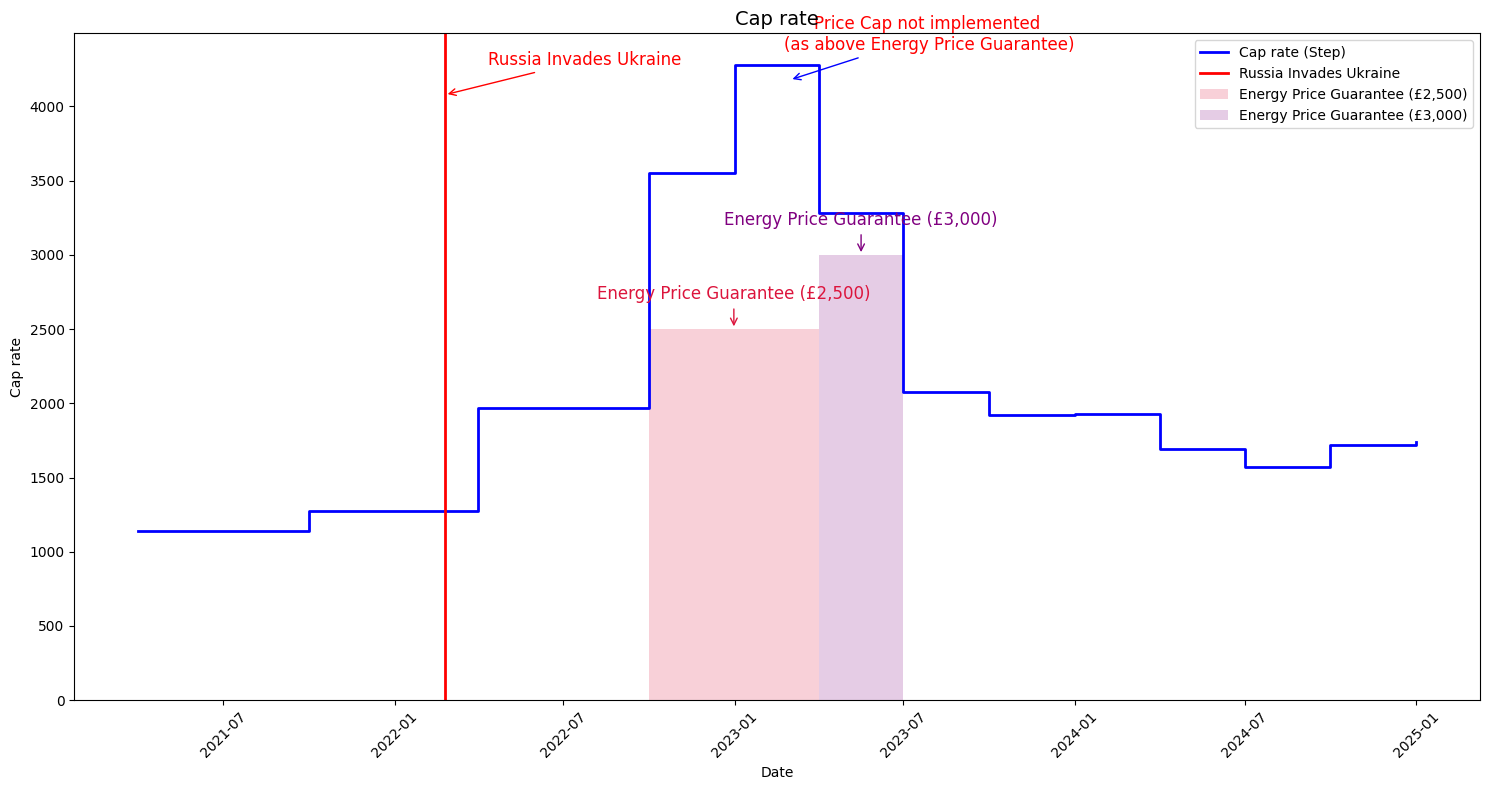

         Date  Cap rate
0  2021-04-01    1138.0
1  2021-10-01    1277.0
2  2022-04-01    1971.0
3  2022-10-01    3549.0
4  2023-01-01    4279.0
5  2023-04-01    3280.0
6  2023-07-01    2074.0
7  2023-10-01    1923.0
8  2024-01-01    1928.0
9  2024-04-01    1690.0
10 2024-07-01    1568.0
11 2024-10-01    1717.0
12 2025-01-01    1738.0
13        NaT       NaN


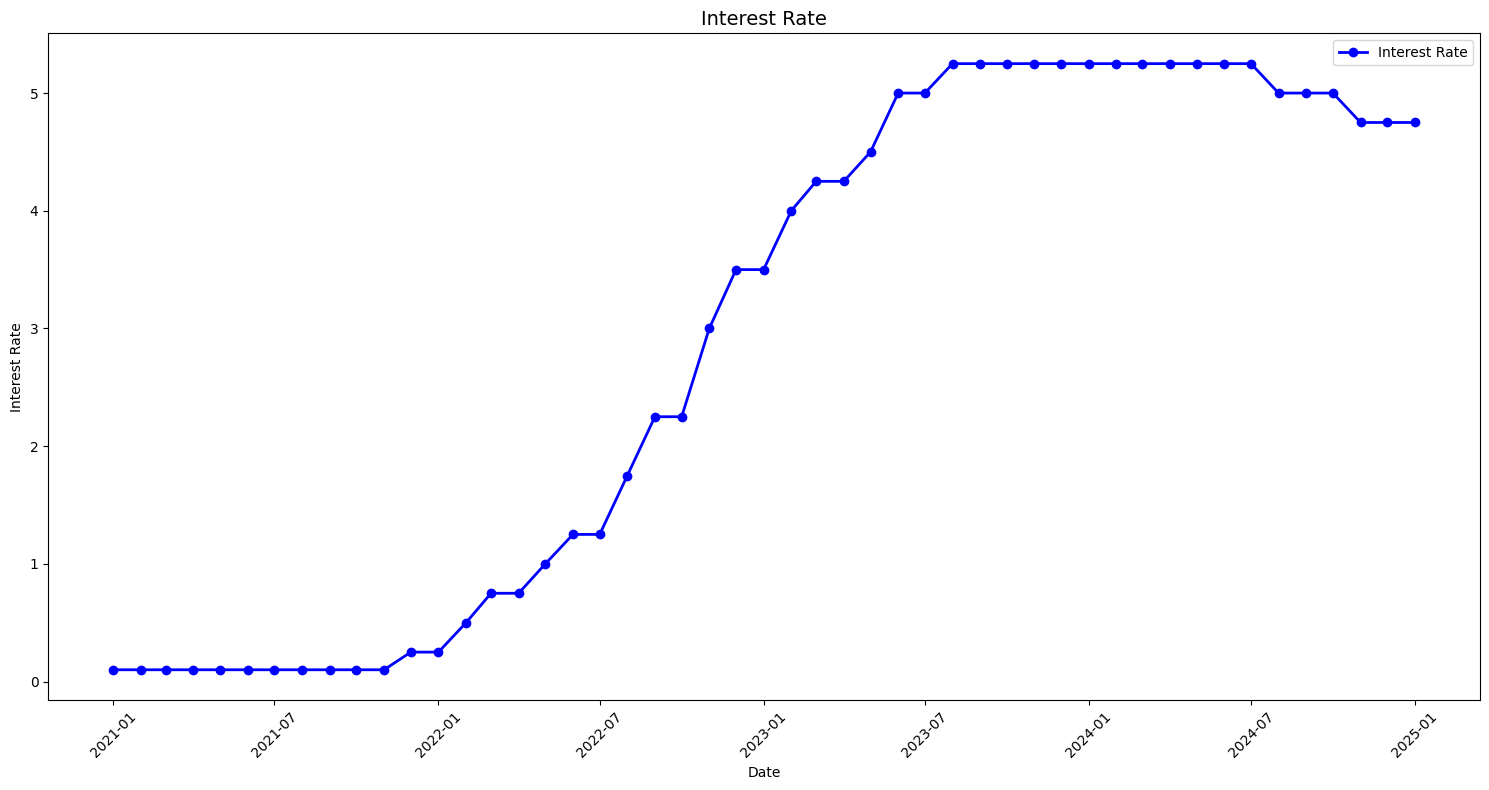

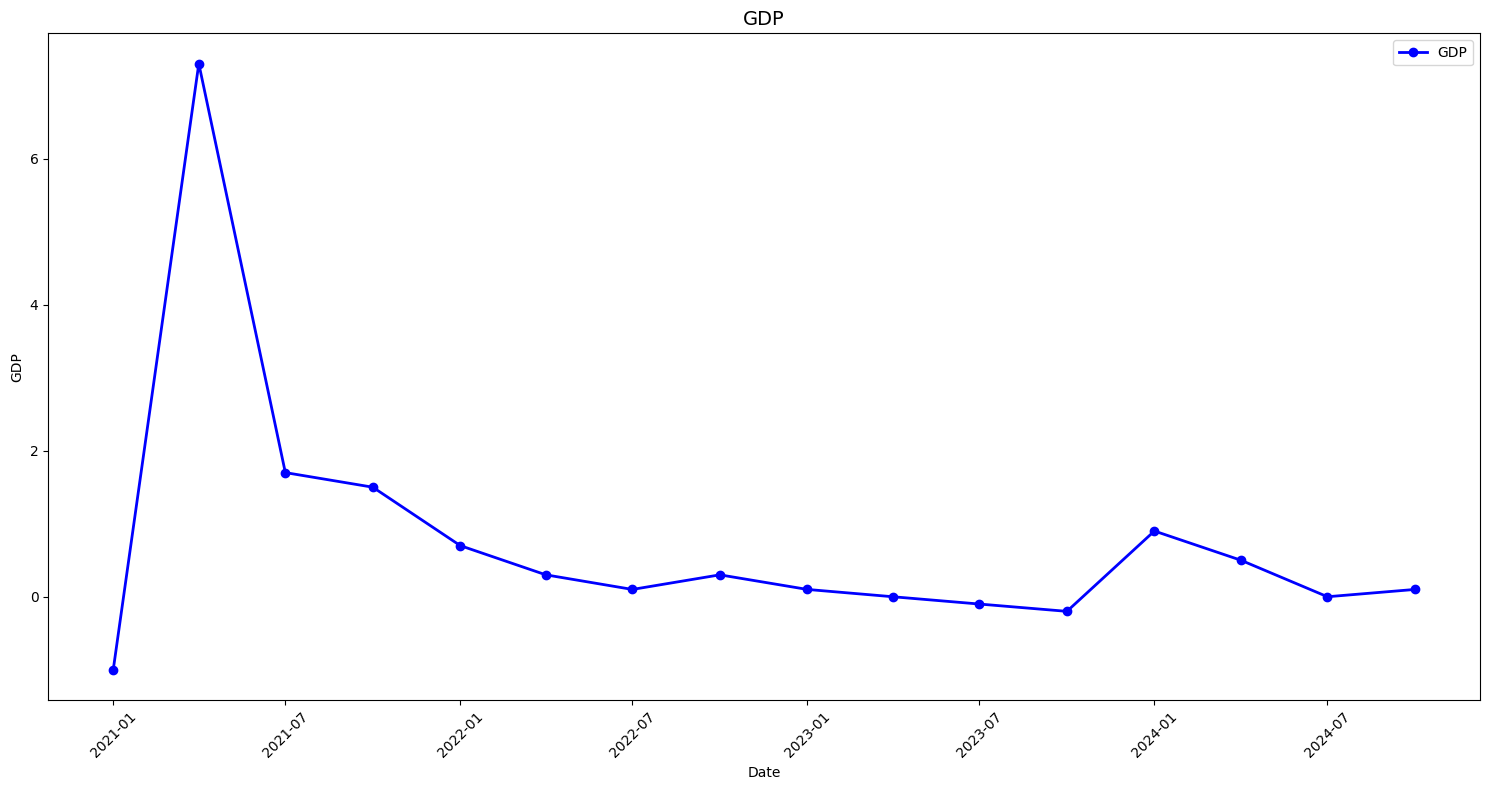

In [ ]:
crisis_year = 2022
target_step_column = 'Cap rate'
annotate_events = {
    "Russia Invades Ukraine": ("2022-02-24", True),
    "Price Cap not implemented \n(as above Energy Price Guarantee)": ("2023-03-01", False)
}

# Define EPG periods
highlight_periods = [
    (pd.to_datetime('2022-10-01'), pd.to_datetime('2023-04-01'), 2500, "Energy Price Guarantee (£2,500)", 'crimson'),
    (pd.to_datetime('2023-04-01'), pd.to_datetime('2023-07-01'), 3000, "Energy Price Guarantee (£3,000)", 'purple')
]

# Loop through each DataFrame in the list for the specific year
for i, df in enumerate(all_dfs[crisis_year]):
    if target_step_column in df.columns:
        # Plot using step chart for the DataFrame if it contains the target column
        plotting(df, step_column=target_step_column, annotation = annotate_events, highlight = highlight_periods)
        print(df)
    else:
        # Plot using regular time series for the DataFrame if it does not contain the target column
        plotting(df)


In [ ]:
target_adjusted_column = 'Cap rate'
# Define the periods for ebs 2500 and ebs 3000 adjustments
periods = [
    {
        'start': '2022-10-01',  # Start date for the first period
        'end': '2023-04-01',  # End date for the first period
        'column': 'Cap rate',  # Column to adjust
        'value': 2500  # Value to set for this period
    },
    {
        'start': '2023-04-01',  # Start date for the second period
        'end': '2023-07-01',  # End date for the second period
        'column': 'Cap rate',  # Column to adjust
        'value': 3000  # Value to set for this period
    }
]

# Loop through each DataFrame in the list for the specific year
for i, df in enumerate(all_dfs[crisis_year]):
    if target_adjusted_column in df.columns:
        # Adjust the DataFrame using the function and directly update it in the list
        all_dfs[crisis_year][i] = adjust_column_for_periods(df, periods)

## Datasets

### Contributions of housing components to the annual CPIH inflation rate

References: https://www.ons.gov.uk/economy/inflationandpriceindices/bulletins/consumerpriceinflation/january2025

### Ofgem (The Office of Gas and Electricity Markets) Price Cap

The Office of Gas and Electricity Markets (Ofgem) regulates the monopoly companies which run the gas and electricity networks. It takes decisions on price controls and enforcement, acting in the interests of consumers and helping the industries to achieve environmental improvements.

References:
https://www.electricityprices.org.uk/history-of-the-energy-price-cap/

### Adjusted Ofgem Price Cap

The Cap rate values are adjusted to account for the impact of government interventions such as the Energy Price Guarantee (EPG). This intervention temporarily reduced the energy bills for households, thus lowering the effective price cap that consumers actually paid.

For example, during periods when the Energy Price Guarantee was set to £2,500 or £3,000, the Cap rate was adjusted to reflect the actual amount consumers were charged, rather than the official Ofgem price cap. This adjustment ensures that the comparison between the price cap and inflation more accurately reflects the real costs faced by consumers during these periods of government support.

### Consumer Confidence

References: https://tradingeconomics.com/united-kingdom/consumer-confidence

### Bank of England Interest Rate

### GBP/USD Exchange Rates

References: https://www.ons.gov.uk/economy/nationalaccounts/balanceofpayments/timeseries/auss/mret

### GDP

References: https://www.ons.gov.uk/economy/grossdomesticproductgdp/timeseries/ihyq/qna


## Combination of multiple indicators

In [ ]:
target_filter_column = "Electricity, gas and other fuels"
filter_target_column(all_dfs, crisis_year, target_filter_column)

In [ ]:
merged_df = merge_dataframes_on_date(*all_dfs[crisis_year])  # Unpack list and pass it as separate arguments
merged_df = normalisation(merged_df)

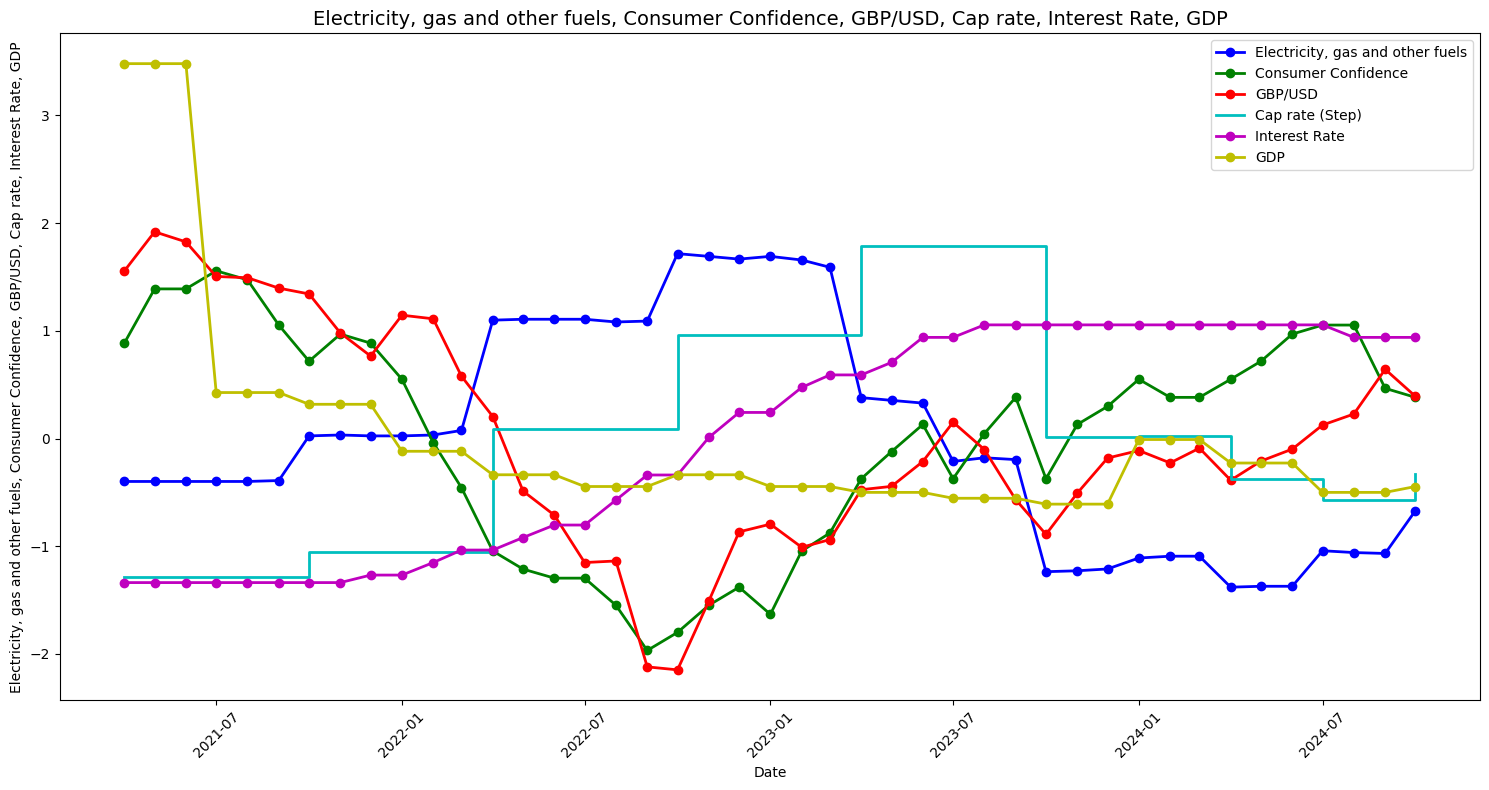

In [ ]:
plotting(merged_df, target_step_column)

## Correlation Heatmap

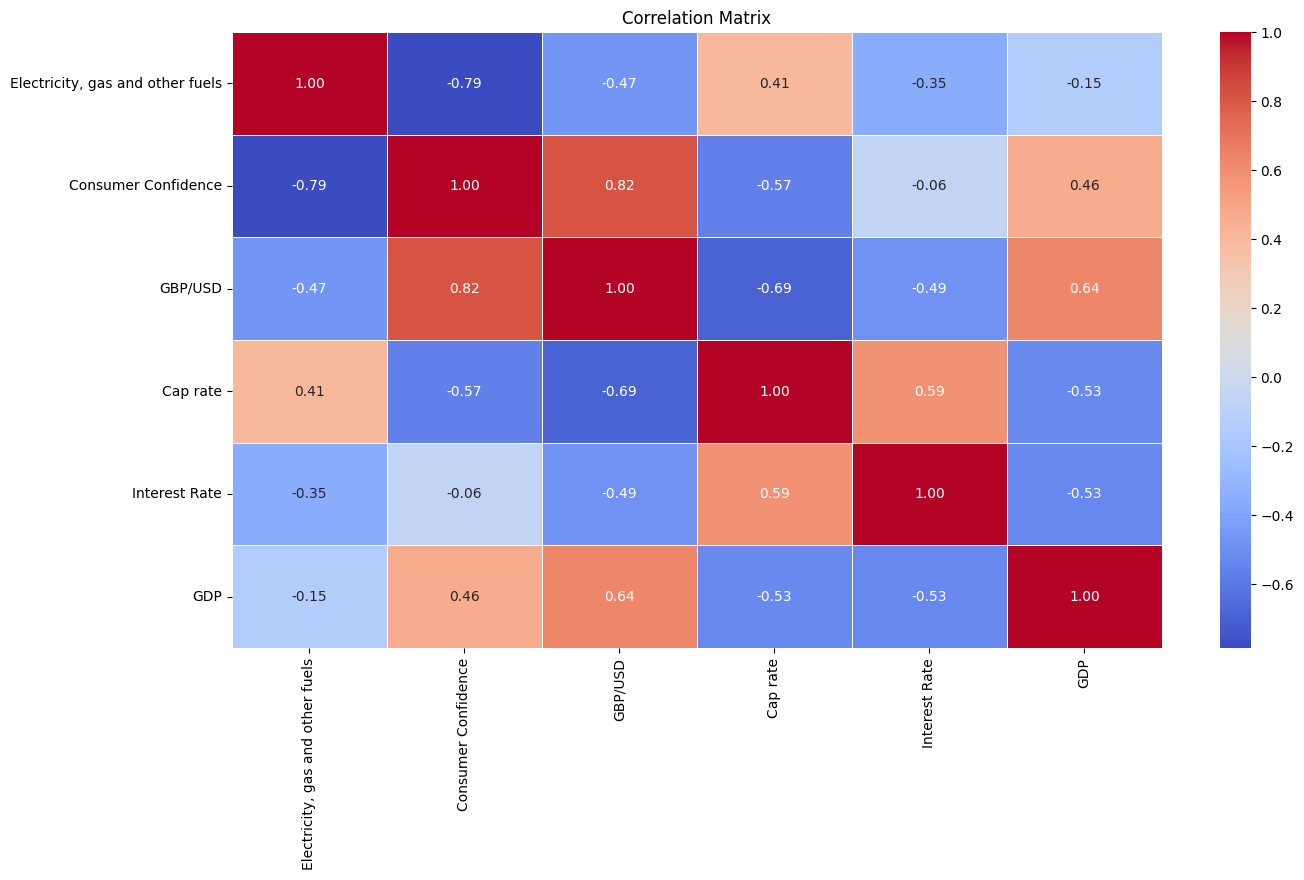

In [ ]:
plot_correlation_matrix(merged_df, 'Correlation Matrix')

## Granger Causality Test

In [ ]:
granger_causality = GrangerCausalityAnalyzer(merged_df, maxlag=10)
granger_causality.run_workflow()

ADF Test for Electricity, gas and other fuels:
ADF Statistic: -1.0124830459009222
p-value: 0.7486842121357413
Critical Values: {'1%': np.float64(-3.596635636000432), '5%': np.float64(-2.933297331821618), '10%': np.float64(-2.6049909750566895)}
Electricity, gas and other fuels is non-stationary (fail to reject null hypothesis)

ADF Test for Differenced Electricity, gas and other fuels:
ADF Statistic: -5.935134128797462
p-value: 2.3305981300359693e-07
Critical Values: {'1%': np.float64(-3.60098336718852), '5%': np.float64(-2.9351348158036012), '10%': np.float64(-2.6059629803688282)}
Differenced Electricity, gas and other fuels is stationary (reject null hypothesis)

ADF Test for Consumer Confidence:
ADF Statistic: -1.2247433308007445
p-value: 0.6628622294805155
Critical Values: {'1%': np.float64(-3.596635636000432), '5%': np.float64(-2.933297331821618), '10%': np.float64(-2.6049909750566895)}
Consumer Confidence is non-stationary (fail to reject null hypothesis)

ADF Test for Differenced

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based chi2 test:   chi2=0.0317  , p=0.8586  , df=1
likelihood ratio test: chi2=0.0317  , p=0.8586  , df=1
parameter F test:         F=0.0294  , p=0.8649  , df_denom=37, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0166  , p=0.9836  , df_denom=34, df_num=2
ssr based chi2 test:   chi2=0.0380  , p=0.9812  , df=2
likelihood ratio test: chi2=0.0380  , p=0.9812  , df=2
parameter F test:         F=0.0166  , p=0.9836  , df_denom=34, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1862  , p=0.3310  , df_denom=31, df_num=3
ssr based chi2 test:   chi2=4.3620  , p=0.2249  , df=3
likelihood ratio test: chi2=4.1293  , p=0.2478  , df=3
parameter F test:         F=1.1862  , p=0.3310  , df_denom=31, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8054  , p=0.5322  , df_denom=28, df_num=4
ssr based chi2 test:   chi2=4.2569  , p=0.3724  , df=4
likelihood ratio test: chi2=4.0293  , p=0.402

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


parameter F test:         F=0.6867  , p=0.6380  , df_denom=25, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.9676  , p=0.4696  , df_denom=22, df_num=6
ssr based chi2 test:   chi2=9.2363  , p=0.1607  , df=6
likelihood ratio test: chi2=8.1969  , p=0.2240  , df=6
parameter F test:         F=0.9676  , p=0.4696  , df_denom=22, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.7782  , p=0.6131  , df_denom=19, df_num=7
ssr based chi2 test:   chi2=9.7485  , p=0.2033  , df=7
likelihood ratio test: chi2=8.5713  , p=0.2849  , df=7
parameter F test:         F=0.7782  , p=0.6131  , df_denom=19, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.5893  , p=0.7729  , df_denom=16, df_num=8
ssr based chi2 test:   chi2=9.7227  , p=0.2850  , df=8
likelihood ratio test: chi2=8.5213  , p=0.3843  , df=8
parameter F test:         F=0.5893  , p=0.7729  , df_denom=16, df_num=8

Granger Causality
number of

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8480  , p=0.3631  , df_denom=37, df_num=1
ssr based chi2 test:   chi2=0.9168  , p=0.3383  , df=1
likelihood ratio test: chi2=0.9064  , p=0.3411  , df=1
parameter F test:         F=0.8480  , p=0.3631  , df_denom=37, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5220  , p=0.5980  , df_denom=34, df_num=2
ssr based chi2 test:   chi2=1.1976  , p=0.5495  , df=2
likelihood ratio test: chi2=1.1796  , p=0.5544  , df=2
parameter F test:         F=0.5220  , p=0.5980  , df_denom=34, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7217  , p=0.5467  , df_denom=31, df_num=3
ssr based chi2 test:   chi2=2.6540  , p=0.4481  , df=3
likelihood ratio test: chi2=2.5654  , p=0.4636  , df=3
parameter F test:         F=0.7217  , p=0.5467  , df_denom=31, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3225  , p=0.8605  , df_d

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=2.7909  , p=0.0605  , df_denom=10, df_num=10
ssr based chi2 test:   chi2=86.5192 , p=0.0000  , df=10
likelihood ratio test: chi2=41.3110 , p=0.0000  , df=10
parameter F test:         F=2.7909  , p=0.0605  , df_denom=10, df_num=10


Granger Causality Test: Electricity, gas and other fuels -> Cap rate

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0050  , p=0.9442  , df_denom=37, df_num=1
ssr based chi2 test:   chi2=0.0054  , p=0.9416  , df=1
likelihood ratio test: chi2=0.0054  , p=0.9416  , df=1
parameter F test:         F=0.0050  , p=0.9442  , df_denom=37, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0090  , p=0.9911  , df_denom=34, df_num=2
ssr based chi2 test:   chi2=0.0206  , p=0.9898  , df=2
likelihood ratio test: chi2=0.0205  , p=0.9898  , df=2
parameter F test:         F=0.0090  , p=0.9911  , df_denom=34, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:        

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


parameter F test:         F=0.0945  , p=0.9625  , df_denom=31, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2567  , p=0.9031  , df_denom=28, df_num=4
ssr based chi2 test:   chi2=1.3570  , p=0.8516  , df=4
likelihood ratio test: chi2=1.3327  , p=0.8558  , df=4
parameter F test:         F=0.2567  , p=0.9031  , df_denom=28, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.9691  , p=0.4555  , df_denom=25, df_num=5
ssr based chi2 test:   chi2=6.9775  , p=0.2223  , df=5
likelihood ratio test: chi2=6.3777  , p=0.2712  , df=5
parameter F test:         F=0.9691  , p=0.4555  , df_denom=25, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.5974  , p=0.7292  , df_denom=22, df_num=6
ssr based chi2 test:   chi2=5.7027  , p=0.4573  , df=6
likelihood ratio test: chi2=5.2831  , p=0.5080  , df=6
parameter F test:         F=0.5974  , p=0.7292  , df_denom=22, df_num=6

Granger Causality
number of

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

parameter F test:         F=0.1944  , p=0.8994  , df_denom=31, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2883  , p=0.8831  , df_denom=28, df_num=4
ssr based chi2 test:   chi2=1.5240  , p=0.8224  , df=4
likelihood ratio test: chi2=1.4934  , p=0.8278  , df=4
parameter F test:         F=0.2883  , p=0.8831  , df_denom=28, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.1969  , p=0.9608  , df_denom=25, df_num=5
ssr based chi2 test:   chi2=1.4173  , p=0.9224  , df=5
likelihood ratio test: chi2=1.3901  , p=0.9254  , df=5
parameter F test:         F=0.1969  , p=0.9608  , df_denom=25, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.2912  , p=0.3020  , df_denom=22, df_num=6
ssr based chi2 test:   chi2=12.3253 , p=0.0551  , df=6
likelihood ratio test: chi2=10.5594 , p=0.1030  , df=6
parameter F test:         F=1.2912  , p=0.3020  , df_denom=22, df_num=6

Granger Causality
number of

## Lasso Regression

Best Alpha: 0.40081120240480966
Selected Features by LASSO: ['GBP/USD', 'Interest Rate']


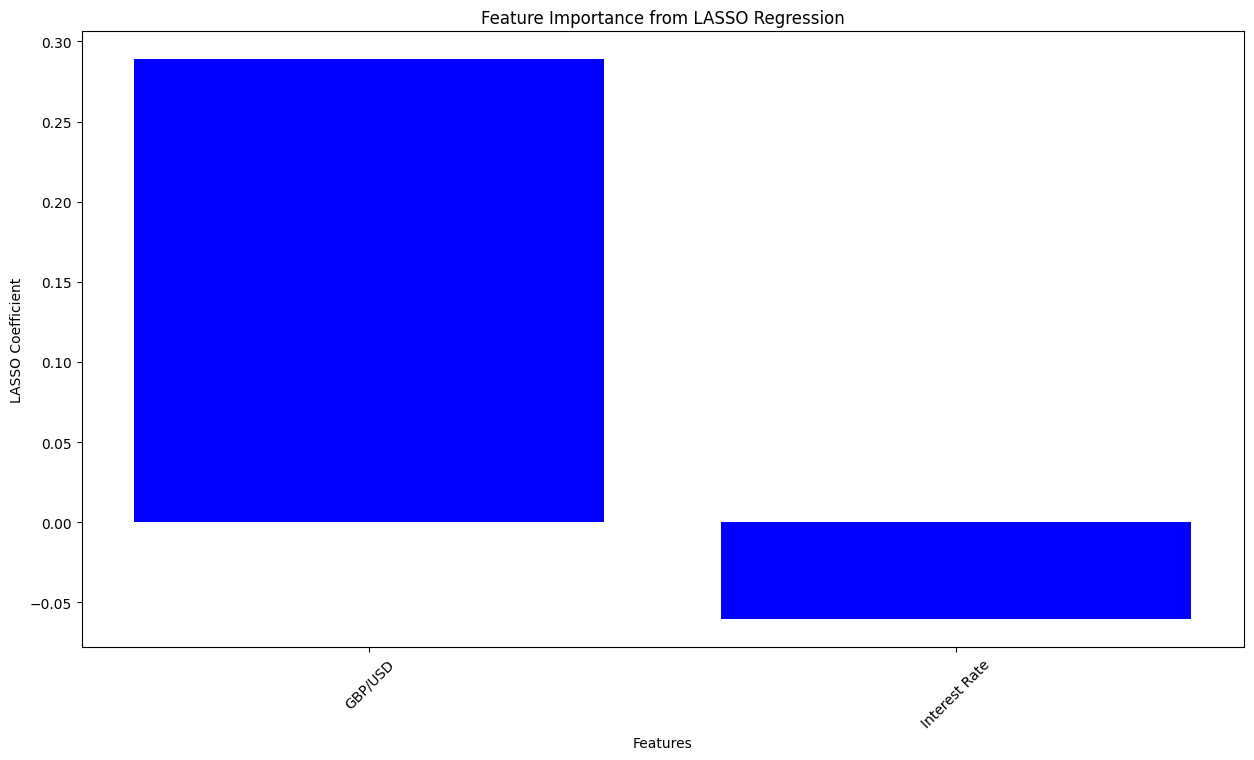

In [ ]:
selected_features = lasso_feature_selection(merged_df, "GDP")

## Multiple Linear Regression

Finding best lags...
Best lags: {'GBP/USD': 4, 'Interest Rate': 6}
Creating lagged dataset...
Training model...
Final Model MSE: 0.044784112601349596


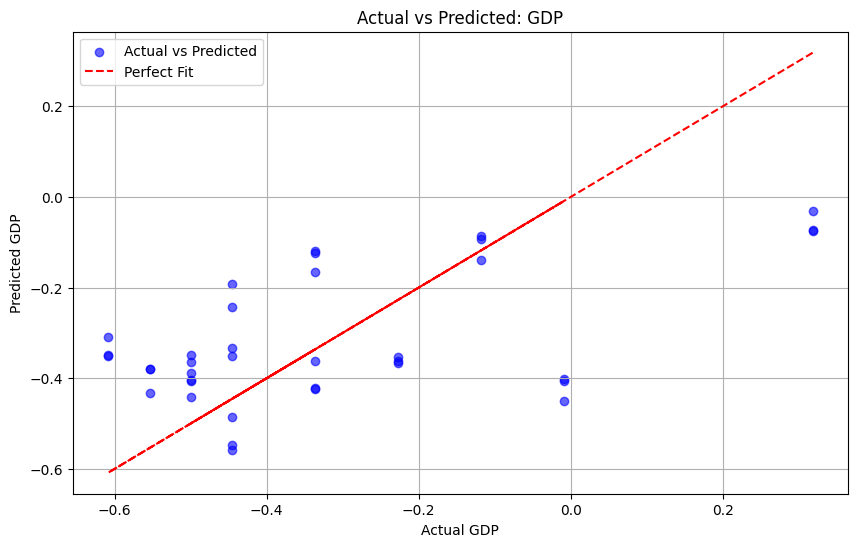

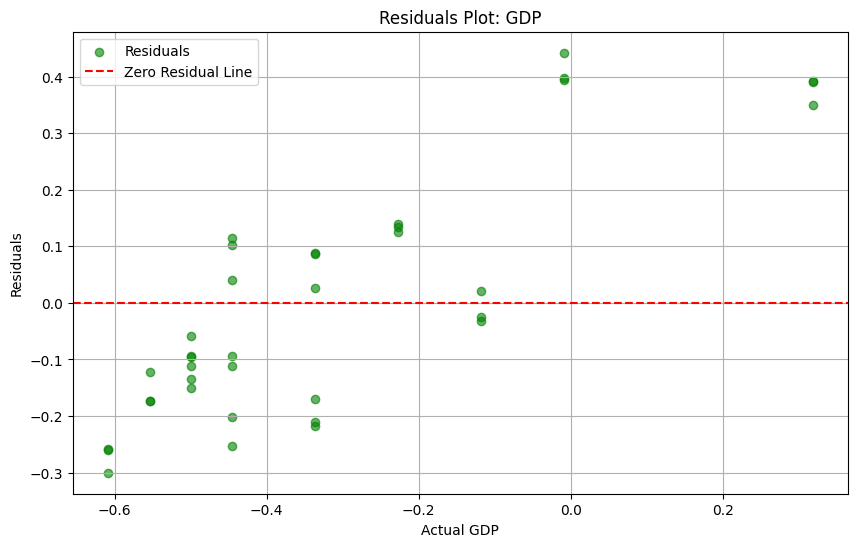

Optimal Lags: {'GBP/USD': 4, 'Interest Rate': 6}
Model MSE: 0.044784112601349596


In [ ]:
# Initialize model
ts_model = TimeSeriesRegression(merged_df, selected_features, 'GDP', max_lag=6)

# Run the full process
ts_model.run()

# Access results
print("Optimal Lags:", ts_model.best_lags)
print("Model MSE:", ts_model.mse)

## 2022 Energy & Inflation Crisis Timeline

https://commonslibrary.parliament.uk/cost-of-living-and-inflation/#:~:text=Energy%20and%20fuel%20prices,-Domestic%20energy%20prices&text=Typical%20household%20energy%20bills%20increased,their%20winter%202021%2F22%20levels.

## Crisis Timeline

**1 October 2021**

- The Ofgem Price Cap level is increased from £1,138 to £1,277 annually for the average household, with Ofgem citing a 50% increase in the wholesale price of gas.

- The number of UK households in fuel poverty rises to 4.5 million, according to National Energy Action estimates.

**27 October 2021**

- Chancellor Rishi Sunak announces no further support for household energy bills in Autumn Budget.

**3 February 2022**

- Heat now, pay later £200 energy bill support loan announced, alongside £150 council tax rebate. This is for everyone who lives in a band A to D property, while in Wales anyone in receipt of council tax reduction is also eligible, irrespective of whichever council tax band they are in. Initially, the UK Government announced it would be received in April but now some councils are saying ‘from April’.

**24 February 2022**

- Russia invades Ukraine, exacerbating wholesale gas price rises.

**1 April 2022**

- The Ofgem Price Cap increases 54% so the average household is now paying £1,971 annually. The government rules out any more support until October. National Energy Action estimates that 6.5 million households are now in fuel poverty.

**26 May 2022**

- Chancellor Rishi Sunak announces a series of cost of living measures:

  - The £200 rebate first announced in February will be doubled to £400 and will be a grant, which means it doesn’t need to be paid back (this is later know as the Energy Bills Support Scheme (EBSS)).

  - People on lowest incomes/means-tested benefits – 8 million households – will receive a one-off ‘Cost of living Payment’ of £650, totalling £5 billion, to be paid in July and Autumn directly to bank accounts.
  
  - Pensioners – 8 million – who are in receipt of Winter Fuel Payment will receive a one-off pensioner cost of living payment of £300.
  
  - Disabled people – 6 million in receipt of non-means-tested disability benefits – will receive a one-off disability payment worth £150. Many will also receive the means-tested benefits £650 payment, so a total of £800 which will offset the average price increase from October.
  
  - Household Support Fund will be extended by £500 million from October and there will be legislation to extend it to all devolved nations.
  
  - One-third of all households will benefit from the Cost of Living Payment.

**3 August 2022**

- Ofgem announces that the Price Cap will now be reviewed every quarter, instead of every six months.

**26 August 2022**

- Ofgem announces that the Price Cap will rise to £3,549 a year from 1 October, leading to calls for more support for households.

**6 September 2022**

- Liz Truss becomes Prime Minister and Kwasi Kwarteng becomes Chancellor.

**8 September 2022**

- The new Prime Minister announces the Energy Price Guarantee, which will commence from 1 October and will override Ofgem’s Energy Price Cap. It is set at £2,500 (annually for an average household) to last until October 2024.

**1 October 2022**

- The average annual household energy bill is now £2,500 as the Energy Price Guarantee comes into effect. National Energy Action estimates that 6.7 million UK households are in fuel poverty. Also, the first of the Energy Bills Support Scheme (EBSS) payments begin for most households.

**18 October 2022**

- Following the market chaos of the 23 September mini-Budget, the government announces that the Energy Price Guarantee will now only last six months, ending in April 2023. There would also be a review into targeted support after April 2023.

**25 October 2022**

- Rishi Sunak becomes Prime Minister and Jeremy Hunt becomes Chancellor.

**16 November 2022**

- The government announces changes to the Warm Home Discount which would see 500,000 households across England and Wales who were previously able to receive it will now not be eligible for this support.

**17 November 2022**

- In the Fiscal Statement, the Chancellor announces that the Energy Price Guarantee will now last until April 2024, but from April 2023 the level will be increased to £3,000 a year for the average household. There will be cost of living payments in 2023 to households on means-tested benefits, households with disabilities and pensioners.

**1 December 2022**

- Fuel Poverty Awareness Day 2022 – National Energy Action announces that increasing the Energy Price Guarantee to £3,000 from April 2023 (as well as the ending of the £400 Energy Bills Support Scheme) will increase the number of households in fuel poverty to 8.4 million.

**15 March 2023**

- In the Budget, it is announced that the Energy Price Guarantee will be kept at £2,500 from April, rather than rising to £3,000.

**1 April 2023**

- Energy Bills Support Scheme ends, meaning that typical households go from paying, effectively, £2,100 annually, to £2,500. National Energy Action estimates there are now 7.5 million households in fuel poverty.

**23 April 2023**

- Government expands scheme offering households using alternative fuels £200 in energy bills support. Called the Alternative Fuels Payment.

**25 May 2023**

- Ofgem announced that, from July, the typical annual energy bill will be £2,074, as the Ofgem price cap comes back into effect. This means that from July, there will be 6.6 million households in fuel poverty.

**30 June 2023**

- Deadline for prepayment meter customers who have not yet accessed the Energy Bills Support Scheme to get their vouchers reissued.

**1 July 2023**

- Energy Price Guarantee ends, because the Ofgem Price Cap is lower than it. The Price Cap means the typical annual bill is £2,074. This means 6.6 million households are in fuel poverty. The prepayment meter premium ends.

**25 August 2023**

- Ofgem announces the Price Cap level for winter 2023. From 1 October, the typical household will pay £1,923 a year. National Energy Action estimates this will leave 6.3 million UK households in fuel poverty.

**1 October 2023**

- The price cap lowers slightly, to £1,923 a year.

**1 January 2024**

- The price cap increases to £1,928 a year. There are changes to Ofgem’s methodology – the regulator has reduced the usage for the ‘typical household’.

**1 April 2024**

- The price cap lowers to £1,690, leaving an estimated 6 million UK households in fuel poverty. National Energy Action also finds that despite the price cap falling £238 a year for typical households from April, 2.3 million households are on average paying more than at the height of the crisis because of energy debt.

**1 July 2024**

- The price cap falls slightly £1,568, meaning that 5.6 million UK households are in fuel poverty.

**1 October 2024**

- The price cap rises to £1,717, pushing the number of UK households in fuel poverty up to 6 million.

**22 November 2024**

- The price cap level for January 2025 is announced. Annual energy bills will be £1,738 a year for a typical household. This is an increase of £21 or 1% from the current level. We announce that this will increase the number of UK households in fuel poverty to 6.1 million.

References:
https://www.nea.org.uk/energy-crisis/energy-crisis-timeline/
